# Imports

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from scipy.stats import lognorm


import warnings
warnings.filterwarnings("ignore")

In [71]:
data = pd.read_csv("da_internship_task_dataset.csv")
data.head()

,uuid,day_id,license,model,feature,requests_cnt,spent_amount
0,user_920,2025-05-01,Premium,Model_A,Feature_1,44.0,16.38
1,user_717,2025-03-04,Premium,Model_B,Feature_2,72.0,27.92
2,user_610,2025-05-08,Premium,Model_A,Feature_2,27.0,9.87
3,user_94,2025-03-11,Basic,Model_D,Feature_1,76.0,14.67
4,user_920,2025-05-14,Premium,Model_E,Feature_3,47.0,9.88


## Looking at the dataset

In [72]:
print(data.describe(),"\n\n",
      data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122746 entries, 0 to 122745
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   uuid          122746 non-null  object 
 1   day_id        122746 non-null  object 
 2   license       122746 non-null  object 
 3   model         122746 non-null  object 
 4   feature       122746 non-null  object 
 5   requests_cnt  122746 non-null  float64
 6   spent_amount  122746 non-null  float64
dtypes: float64(2), object(5)
memory usage: 6.6+ MB
        requests_cnt   spent_amount
count  122746.000000  122746.000000
mean       51.260742      12.227798
std       167.977380      37.588494
min         1.000000       0.270000
25%        18.000000       5.140000
50%        32.000000       8.020000
75%        54.000000      13.060000
max     12900.000000    2599.000000 

 None


In [73]:
with pd.option_context('display.max_colwidth', None):
      display(data.apply(lambda x: (x.unique(), len(x.unique())) if len(x.unique()) < 10 else len(x.unique()) ))

uuid                                                                    1866
day_id                                                                    92
license                          ([Premium, Basic, Enterprise, Standard], 4)
model                     ([Model_A, Model_B, Model_D, Model_E, Model_C], 5)
feature         ([Feature_1, Feature_2, Feature_3, Feature_5, Feature_4], 5)
requests_cnt                                                             452
spent_amount                                                            5648
dtype: object

In [74]:
len(data.filter(['uuid']).drop_duplicates())
# number of users who at least once used any model in March, April or May

1866

No nulls, clean data

# EDA

In [75]:
users_licenses = data.sort_values('day_id').groupby(['uuid', 'license'])['day_id'].last().reset_index()
licenses_count = users_licenses.groupby('uuid').size().reset_index(name='license_count')

users_licenses = users_licenses.merge(licenses_count, on='uuid', how='left')

users_licenses[users_licenses['license_count'] == 2] #.drop_duplicates('uuid') #57


,uuid,license,day_id,license_count
13,user_110,Basic,2025-05-31,2
14,user_110,Standard,2025-05-30,2
21,user_111,Basic,2025-05-29,2
22,user_111,Standard,2025-05-30,2
23,user_1110,Basic,2025-05-30,2
...,...,...,...,...
1011,user_197,Standard,2025-05-30,2
1021,user_198,Basic,2025-05-30,2
1022,user_198,Enterprise,2025-05-29,2
1029,user_199,Basic,2025-05-31,2


Some users changed their license during those 3 months. Only 57 though.

In [76]:
data_sorted = data.sort_values(['uuid', 'day_id'])

license_history = (
    data_sorted
    .groupby('uuid')['license']
    .apply(lambda x: list(dict.fromkeys(x)))
    .reset_index(name='licenses')
)

license_history['first_license'] = license_history['licenses'].str[0]
license_history['last_license'] = license_history['licenses'].str[-1]

transition_matrix = pd.crosstab(
    index=license_history['first_license'],
    columns=license_history['last_license']
)

user_licenses = ['Basic', 'Standard', 'Premium', 'Enterprise']
transition_matrix = transition_matrix.reindex(index=user_licenses, columns=user_licenses, fill_value=0)

transition_matrix

last_license,Basic,Standard,Premium,Enterprise
first_license,,,,
Basic,675,8,2,5
Standard,19,666,1,4
Premium,6,4,234,0
Enterprise,2,6,0,234


Matrix showing what license users started with and what license they ended having.

In [77]:
data['day_id'] = pd.to_datetime(data['day_id'])

data['month'] = data['day_id'].dt.month_name()

months = ['March', 'April', 'May']
licenses = ['Basic', 'Standard', 'Premium', 'Enterprise']

# For each user and month, take the *latest* license in that month
user_month_license = (
    data.sort_values(['uuid', 'day_id'])
        .groupby(['uuid', 'month'])['license']
        .last()
        .unstack()  # columns: March, April, May
)

def build_transition_matrix(df, col_from, col_to, all_licenses):
    """Return a stochastic (row-normalized) transition matrix."""
    counts = pd.crosstab(df[col_from], df[col_to])
    counts = counts.reindex(index=all_licenses, columns=all_licenses, fill_value=0)
    # normalize rows (stochastic)
    stochastic = counts.div(counts.sum(axis=1), axis=0).fillna(0)
    return stochastic

march_to_april = build_transition_matrix(user_month_license, 'March', 'April', licenses)
april_to_may = build_transition_matrix(user_month_license, 'April', 'May', licenses)

# --- 3 Display results ---
print("\nMarch → April (stochastic transition matrix):")
display(march_to_april.round(3))

print("\nApril → May (stochastic transition matrix):")
display(april_to_may.round(3))



March → April (stochastic transition matrix):


April,Basic,Standard,Premium,Enterprise
March,,,,
Basic,0.978,0.010,0.006,0.006
Standard,0.006,0.990,0.002,0.002
Premium,0.000,0.004,0.996,0.000
Enterprise,0.000,0.013,0.000,0.987



April → May (stochastic transition matrix):


May,Basic,Standard,Premium,Enterprise
April,,,,
Basic,0.988,0.009,0.002,0.002
Standard,0.005,0.986,0.003,0.005
Premium,0.013,0.004,0.983,0.000
Enterprise,0.021,0.008,0.000,0.971


In [78]:
data[data['uuid']=='user_110'].sort_values('day_id') # why some users change back and forth licenses?

,uuid,day_id,license,model,feature,requests_cnt,spent_amount,month
98603,user_110,2025-03-03,Basic,Model_A,Feature_1,11.0,2.91,March
121793,user_110,2025-03-03,Basic,Model_A,Feature_2,7.0,2.84,March
83469,user_110,2025-03-04,Standard,Model_C,Feature_3,43.0,10.43,March
11773,user_110,2025-03-05,Basic,Model_A,Feature_2,10.0,3.49,March
47380,user_110,2025-03-06,Basic,Model_A,Feature_3,12.0,5.05,March
...,...,...,...,...,...,...,...,...
81307,user_110,2025-05-29,Standard,Model_A,Feature_1,15.0,5.87,May
37554,user_110,2025-05-30,Standard,Model_C,Feature_5,36.0,7.92,May
105291,user_110,2025-05-30,Basic,Model_A,Feature_2,27.0,9.86,May
42927,user_110,2025-05-31,Basic,Model_A,Feature_2,26.0,8.59,May


#### Checking license distribution among users 

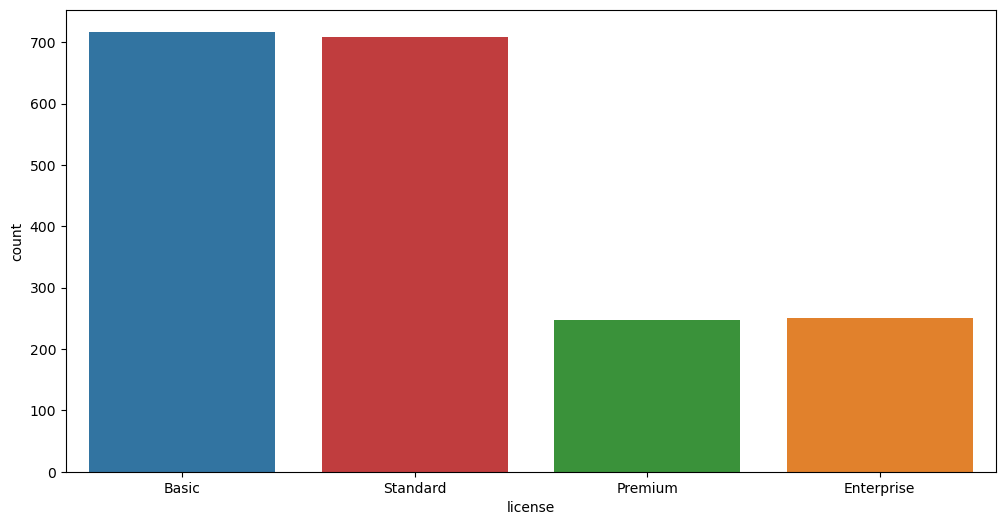

In [79]:
licenses = data.filter(['uuid', 'license']).drop_duplicates().groupby(['license']).size().reset_index(name='count')

plt.figure(figsize=(12,6))
sns.barplot(data=licenses, x='license', y='count', hue='license', palette='tab10', order=['Basic', 'Standard', 'Premium', 'Enterprise'])
plt.show()

#### Checking days active by users license

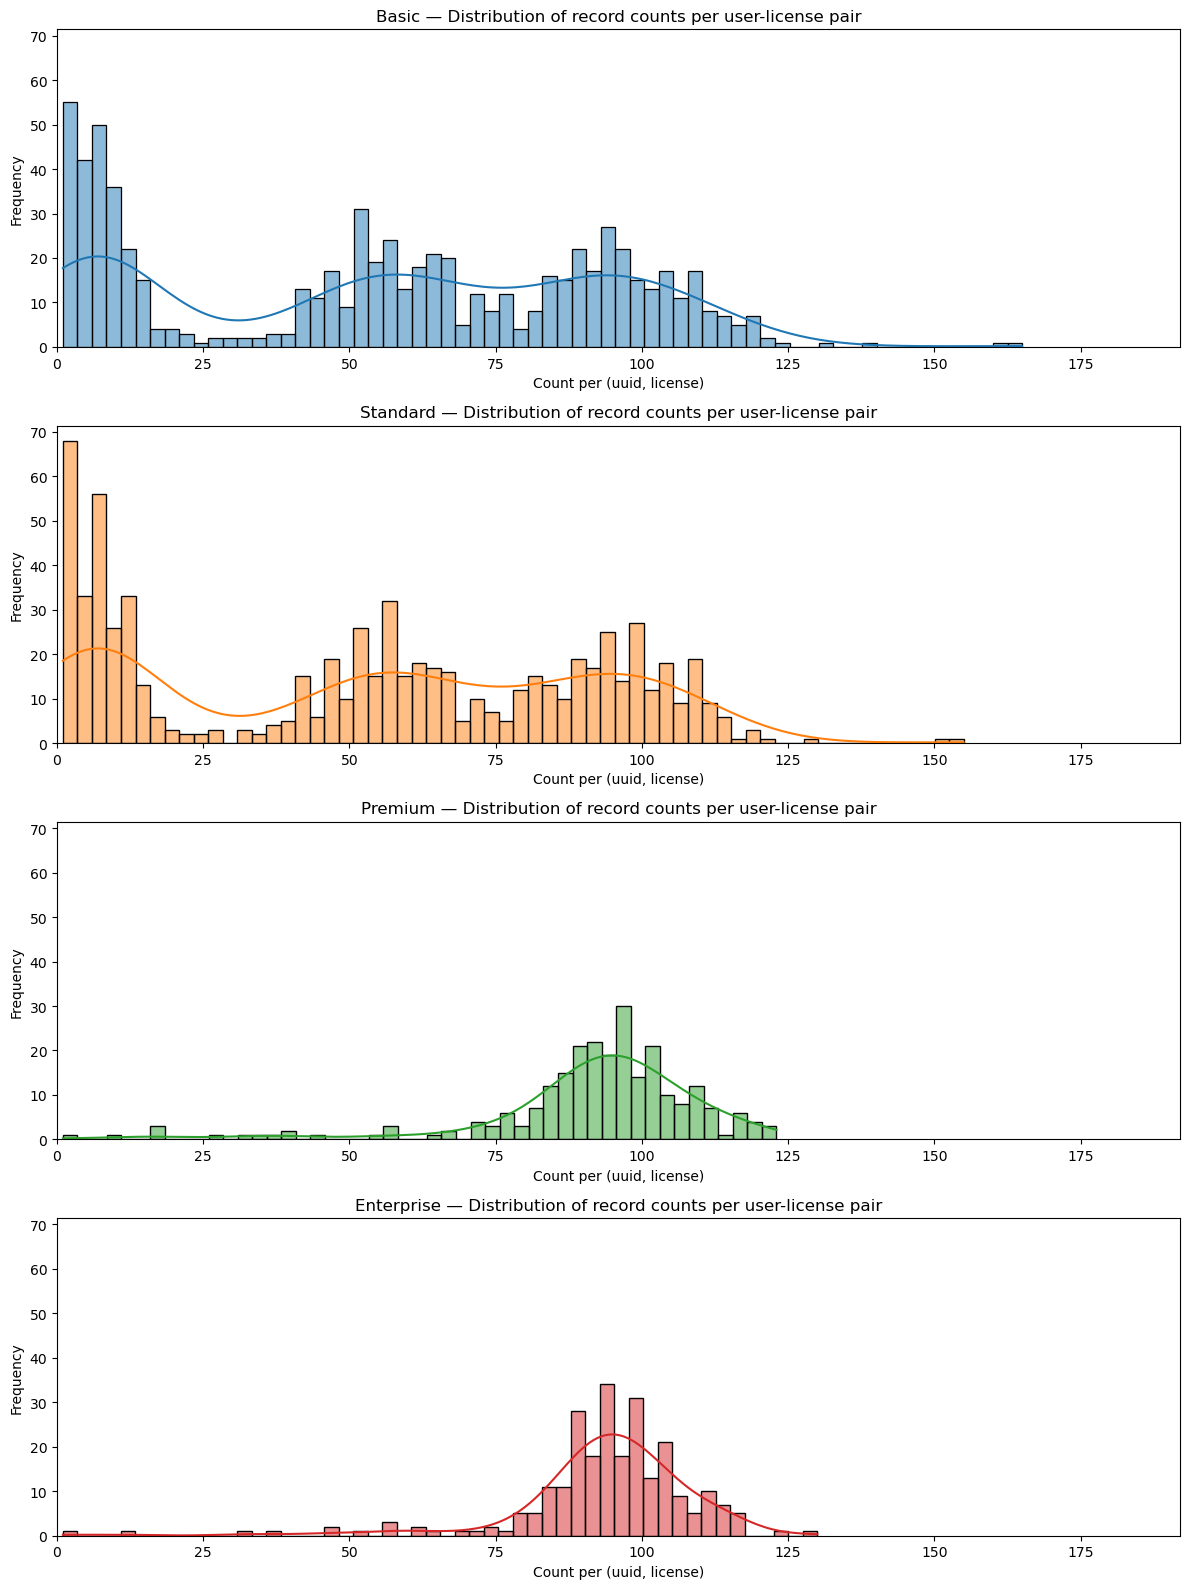

In [80]:
user_licenses = ['Basic', 'Standard', 'Premium', 'Enterprise']
num_licenses = len(user_licenses)

fig, axes = plt.subplots(num_licenses, 1, figsize=(12, 4 * num_licenses))
palette = sns.color_palette("tab10", num_licenses)

max_xlim = data.groupby(['uuid']).size().max()

for i, user_license in enumerate(user_licenses):
    subset = data[data['license'] == user_license].copy()
    plotdata = subset.groupby(['uuid']).size().reset_index(name='count')

    sns.histplot(
        plotdata['count'],
        #bins=50,
        binwidth=2.5,
        kde=True,
        color=palette[i],
        ax=axes[i]
    )

    axes[i].set_xlabel("Count per (uuid, license)")
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"{user_license} — Distribution of record counts per user-license pair")
    axes[i].set_xlim(0, max_xlim)

ymax = max(ax.get_ylim()[1] for ax in axes)
for ax in axes:
    ax.set_ylim(0, ymax)
    
plt.tight_layout()
plt.show()


We can clearly see that Basic and Standard users are very similar in terms of activity. Same goes for Premium and Enterprise.

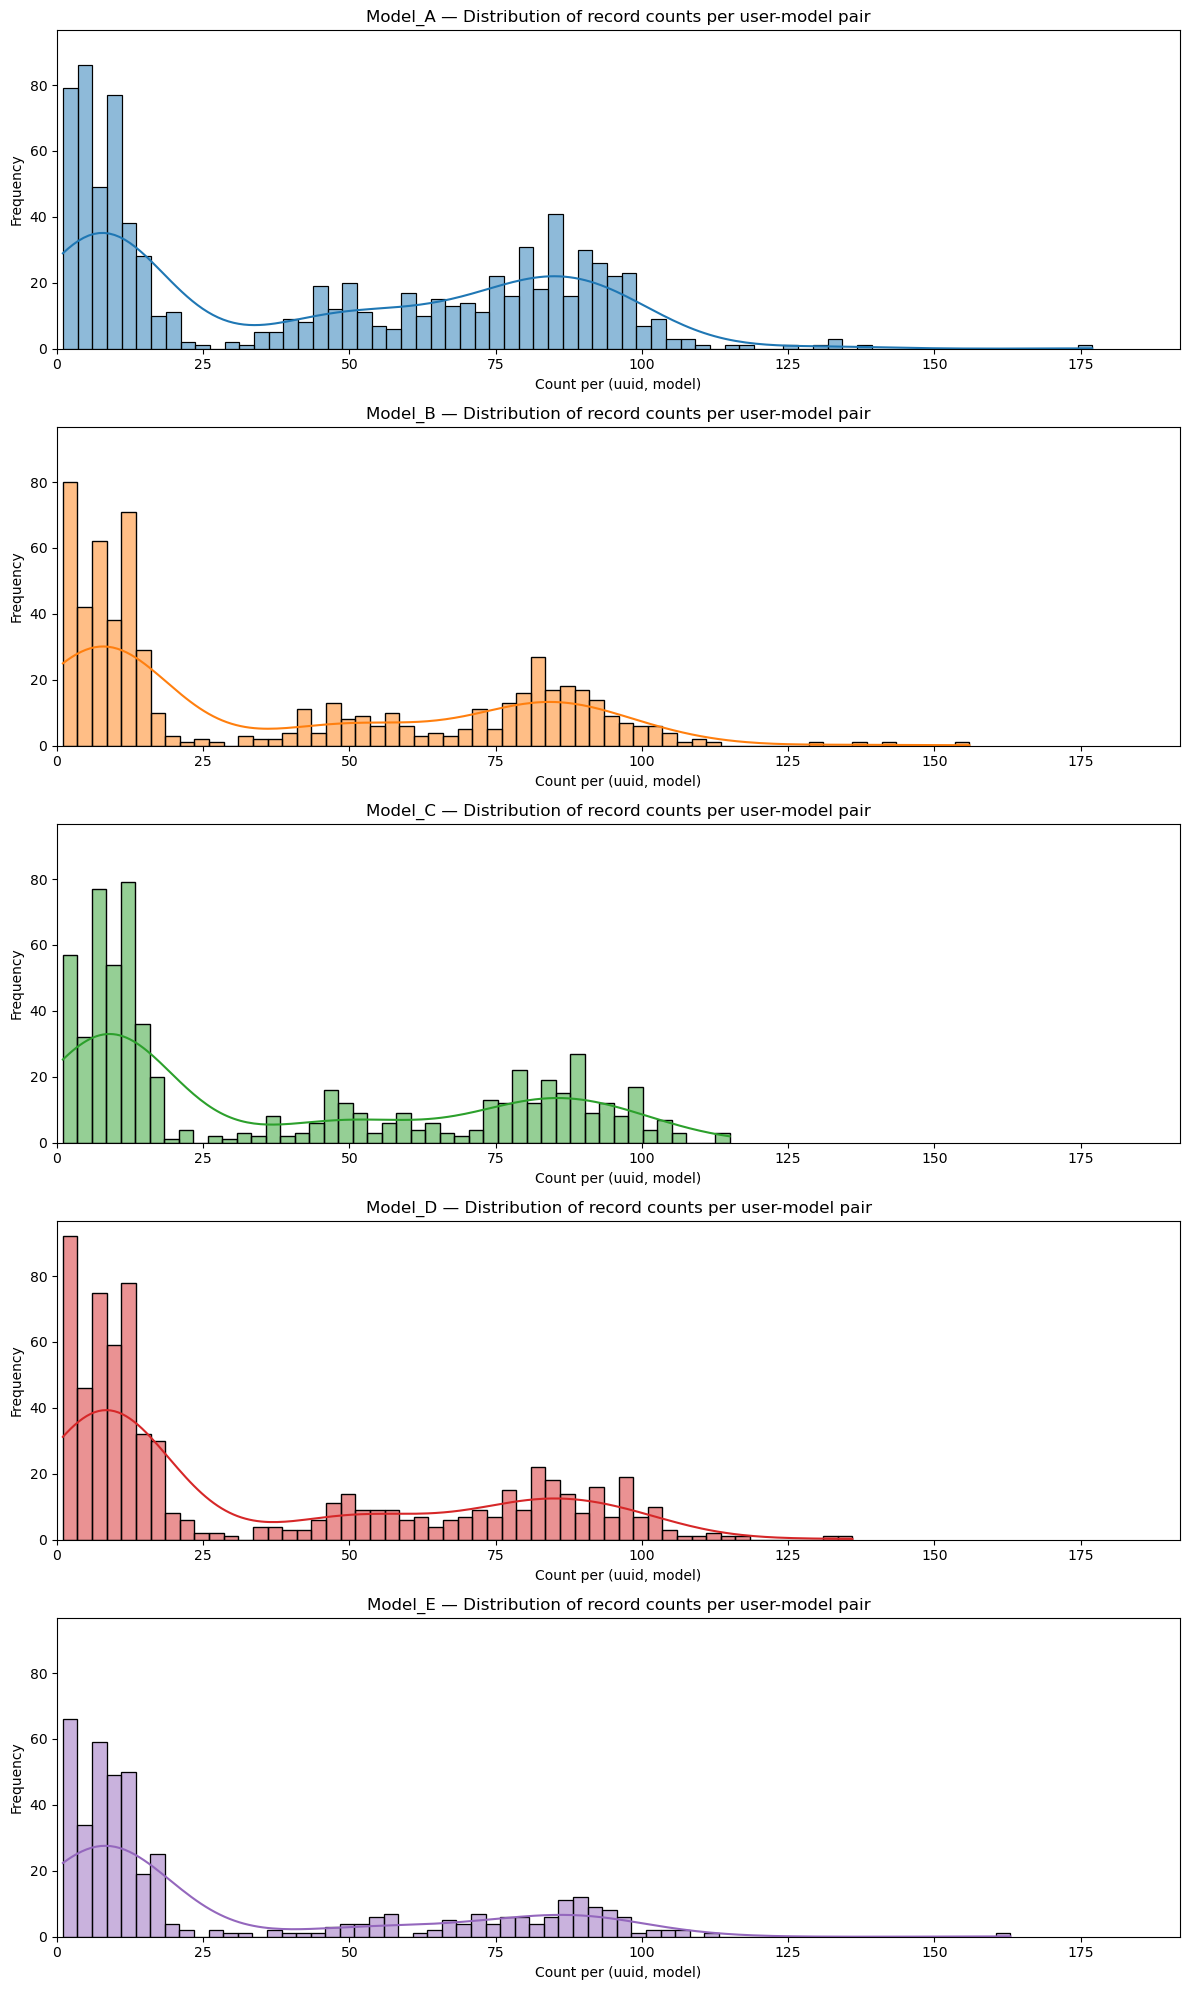

In [81]:
models = sorted(data['model'].unique())
num_models = len(models)

fig, axes = plt.subplots(num_models, 1, figsize=(12, 4 * num_models))
palette = sns.color_palette("tab10", num_models)

max_xlim = data.groupby(['uuid']).size().max()

for i, model in enumerate(models):
    subset = data[data['model'] == model].copy()
    plotdata = subset.groupby(['uuid']).size().reset_index(name='count')

    sns.histplot(
        plotdata['count'],
        #bins=50,
        binwidth=2.5,
        kde=True,
        color=palette[i],
        ax=axes[i]
    )

    axes[i].set_xlabel("Count per (uuid, model)")
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"{model} — Distribution of record counts per user-model pair")
    axes[i].set_xlim(0, max_xlim)

ymax = max(ax.get_ylim()[1] for ax in axes)
for ax in axes:
    ax.set_ylim(0, ymax)

plt.tight_layout()
plt.show()


No insights on plots above.

#### Checking requests and spendings distributions based on license

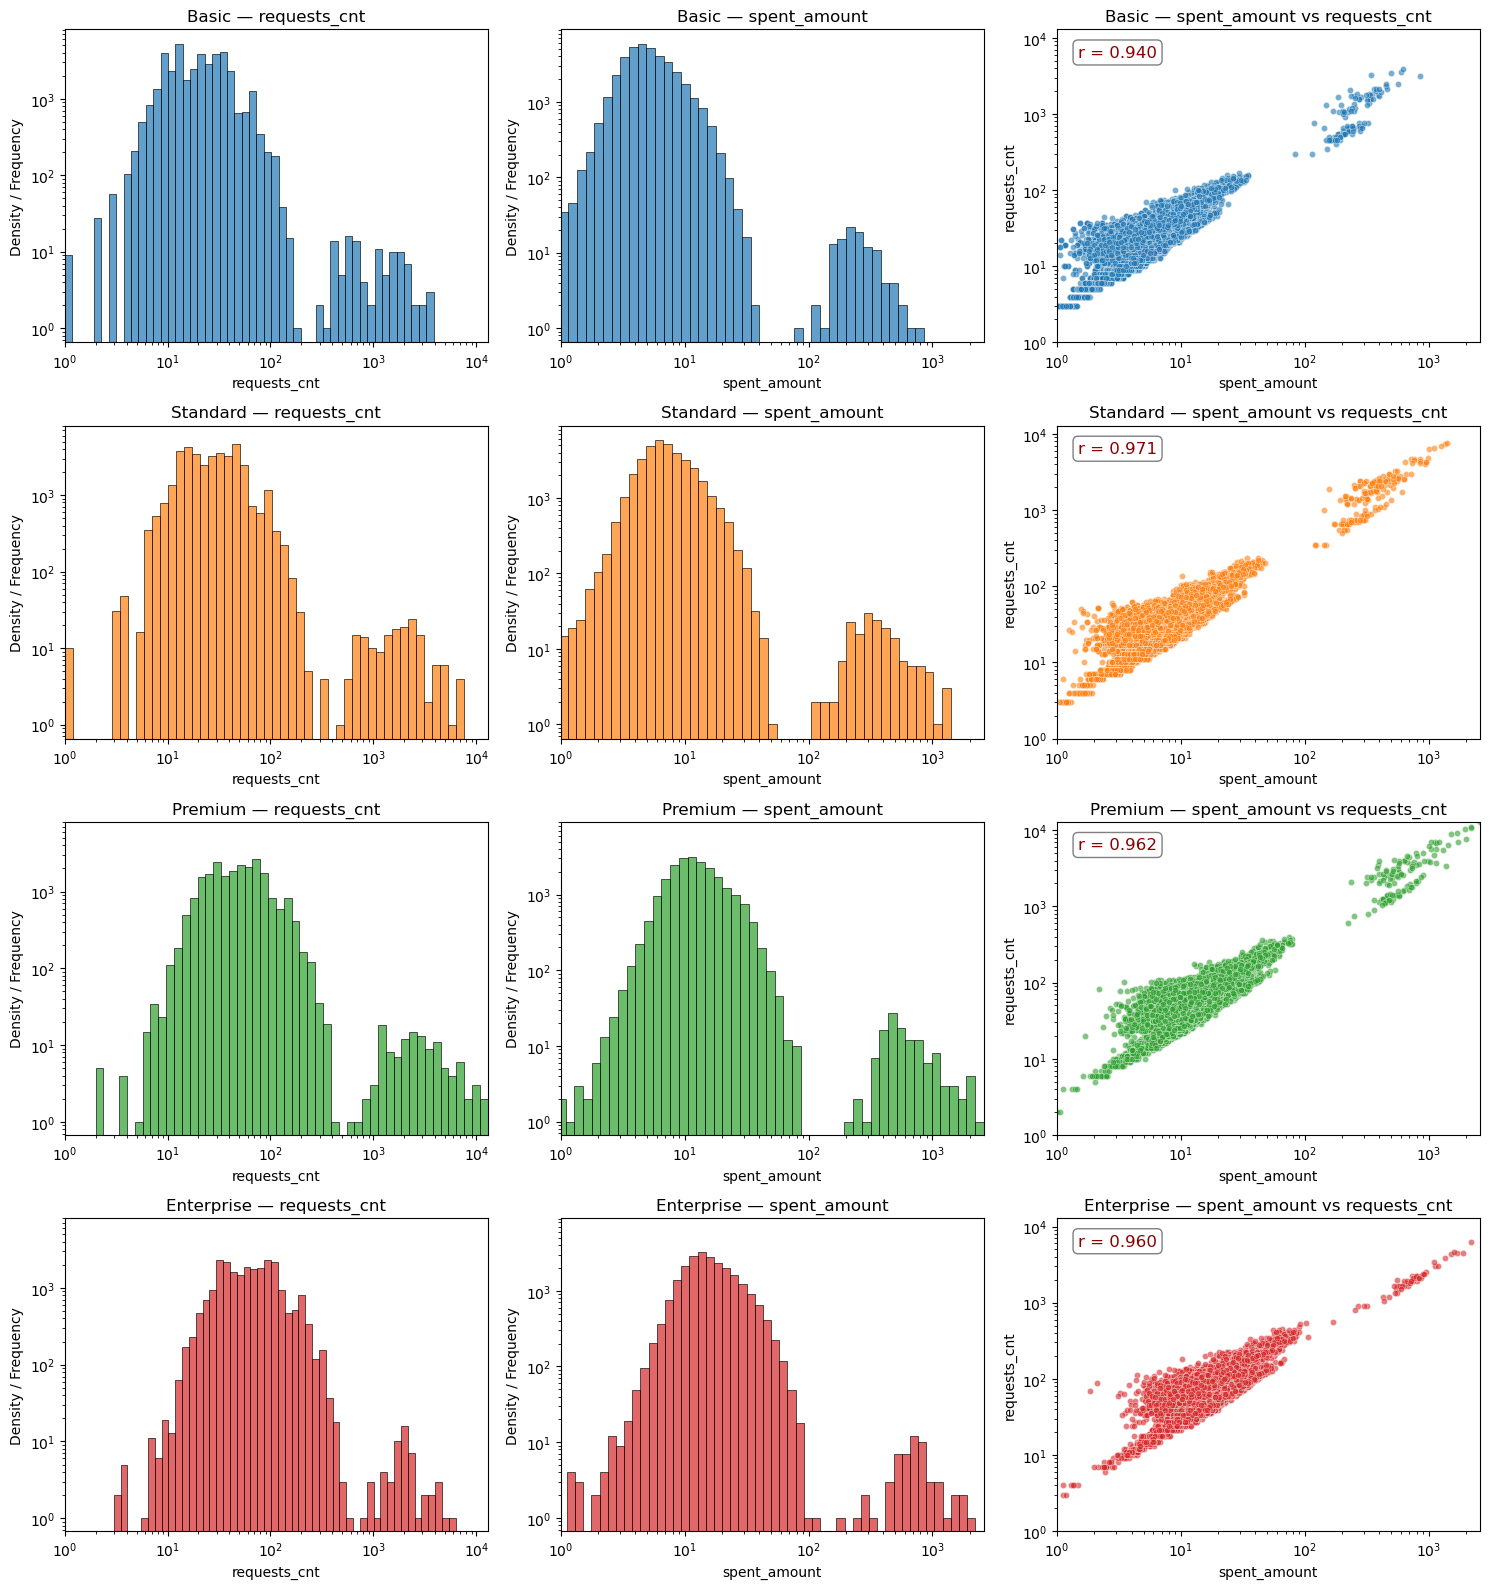

In [82]:
user_licenses = ['Basic', 'Standard', 'Premium', 'Enterprise']
num_licenses = len(user_licenses)
use_log_scale = True

req_all = data['requests_cnt']
spent_all = data['spent_amount']

req_xmin, req_xmax = 1, req_all.max()
spent_xmin, spent_xmax = 1, spent_all.max()

fig, axes = plt.subplots(num_licenses, 3, figsize=(15, 4 * num_licenses))
palette = sns.color_palette("tab10", num_licenses)

for i, user_license in enumerate(user_licenses):
    subset = data[data['license'] == user_license].copy()

    # Hist 1
    sns.histplot(
        subset['requests_cnt'],
        bins=50,
        log_scale=use_log_scale,
        color=palette[i],
        ax=axes[i, 0],
        alpha=0.7
    )
    if use_log_scale:
        axes[i, 0].set_xscale('log')
        axes[i, 0].set_yscale('log')
    axes[i, 0].set_xlim(req_xmin, req_xmax)
    axes[i, 0].set_title(f"{user_license} — requests_cnt")
    axes[i, 0].set_xlabel("requests_cnt")
    axes[i, 0].set_ylabel("Density / Frequency")

    # Hist 2
    sns.histplot(
        subset['spent_amount'],
        bins=50,
        log_scale=use_log_scale,
        color=palette[i],
        ax=axes[i, 1],
        alpha=0.7
    )
    if use_log_scale:
        axes[i, 1].set_xscale('log')
        axes[i, 1].set_yscale('log')
    axes[i, 1].set_xlim(spent_xmin, spent_xmax)
    axes[i, 1].set_title(f"{user_license} — spent_amount")
    axes[i, 1].set_xlabel("spent_amount")
    axes[i, 1].set_ylabel("Density / Frequency")

    # scatter
    sns.scatterplot(
        x=subset['spent_amount'],
        y=subset['requests_cnt'],
        color=palette[i],
        s=20,
        alpha=0.6,
        ax=axes[i, 2]
    )
    if use_log_scale:
        axes[i, 2].set_xscale('log')
        axes[i, 2].set_yscale('log')
    axes[i, 2].set_xlim(spent_xmin, spent_xmax)
    axes[i, 2].set_ylim(req_xmin, req_xmax)
    axes[i, 2].set_title(f"{user_license} — spent_amount vs requests_cnt")
    axes[i, 2].set_xlabel("spent_amount")
    axes[i, 2].set_ylabel("requests_cnt")

    # corr
    if subset['spent_amount'].notna().any() and subset['requests_cnt'].notna().any():
        corr = subset[['spent_amount', 'requests_cnt']].corr().iloc[0, 1]
        axes[i, 2].text(
            0.05, 0.95,
            f"r = {corr:.3f}",
            transform=axes[i, 2].transAxes,
            fontsize=12,
            color='darkred',
            verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1)
        )

# Unify y-limits for histograms
y_max_req = max(ax.get_ylim()[1] for ax in axes[:, 0])
y_max_spent = max(ax.get_ylim()[1] for ax in axes[:, 1])
for i in range(num_licenses):
    axes[i, 0].set_ylim(0, y_max_req)
    axes[i, 1].set_ylim(0, y_max_spent)

plt.tight_layout()
plt.show()


Most users send around 10-300 requests a day, then there is another group of users who are sending around 1000 requests a day. 

There is a gap between normal users and 'powerusers'. This gap starts earlier for lower licenses.

Requests and spendings are lineary correlated, with small exceptions for smaller amounts of requests.

#### Checking license vs model distributions

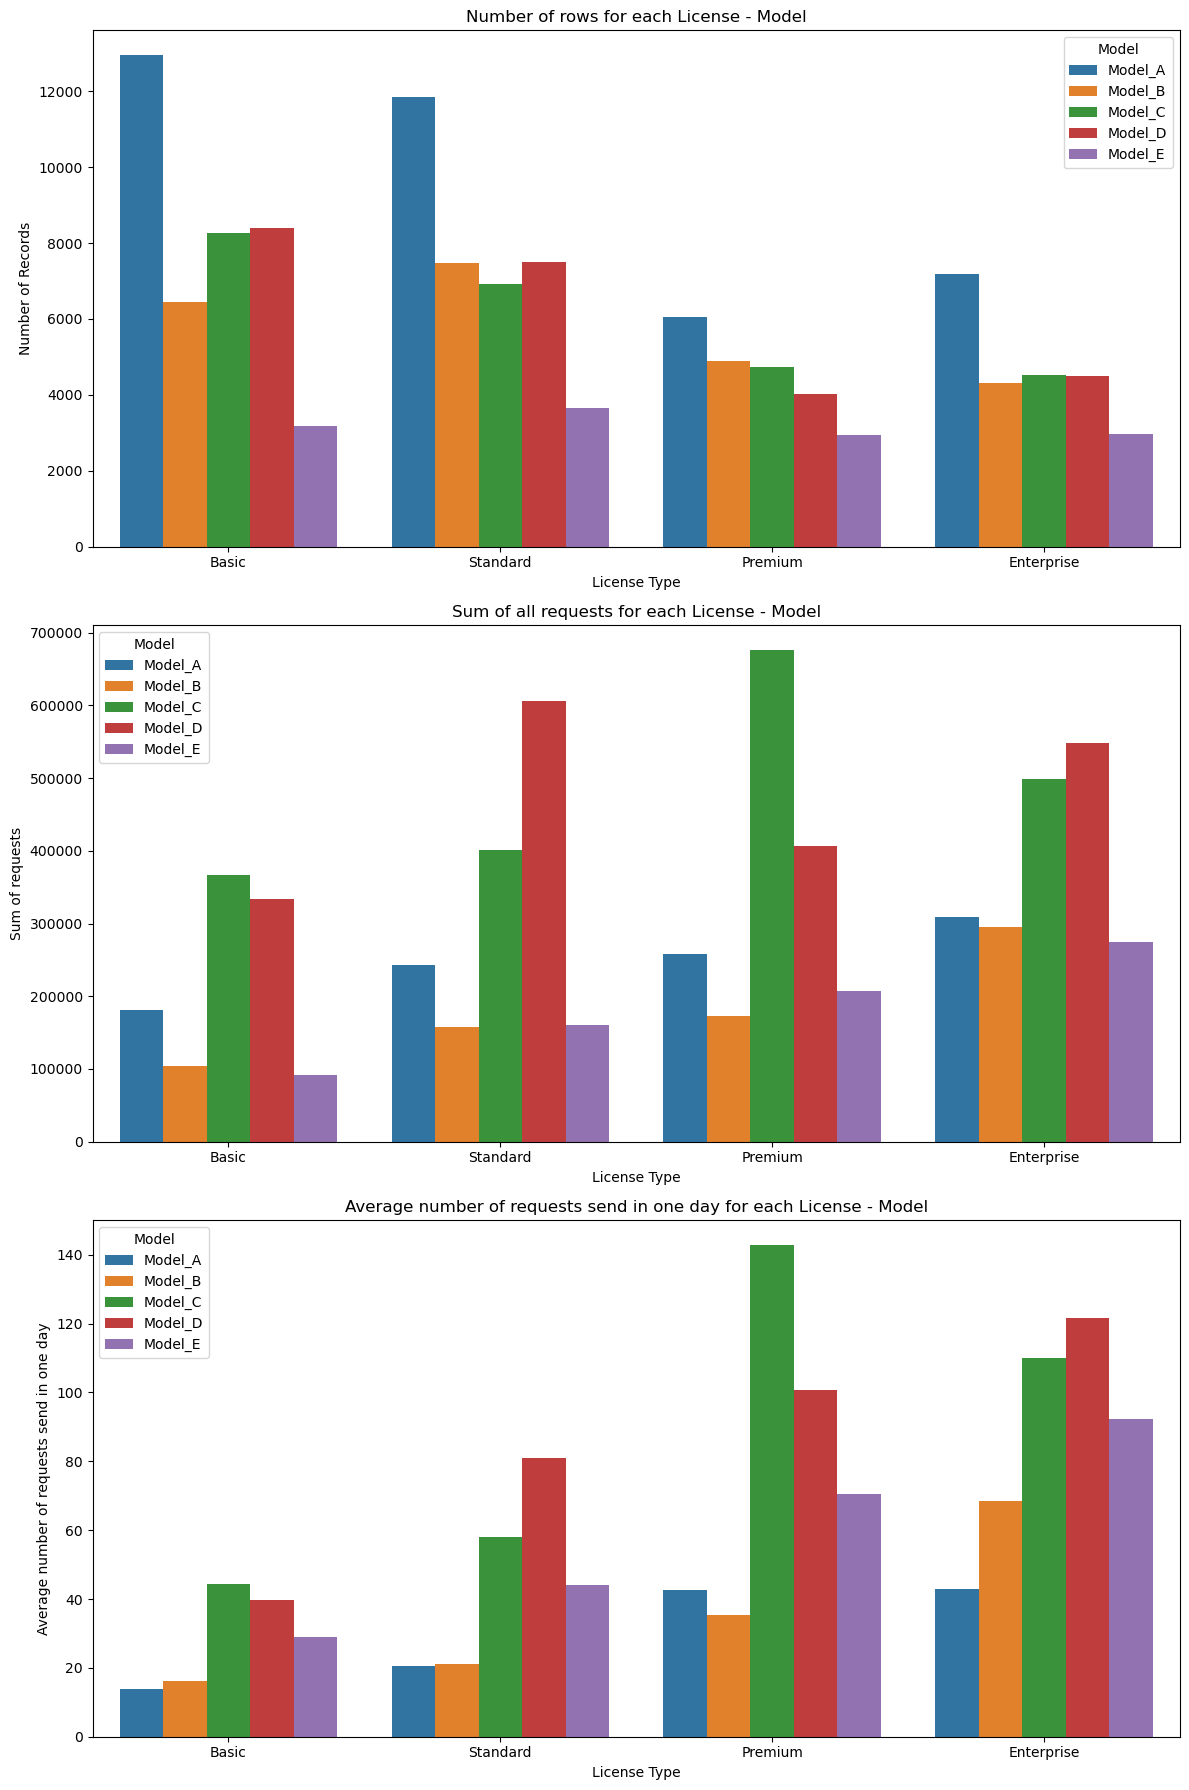

In [83]:
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Define license order
license_order = ['Basic', 'Standard', 'Premium', 'Enterprise']

# License vs Model barplot
license_model = data.groupby(['license', 'model']).size().reset_index(name='count')

# Absolute counts
sns.barplot(data=license_model, x='license', y='count', hue='model', palette='tab10', ax=axes[0], order=license_order)
axes[0].set_title('Number of rows for each License - Model')
axes[0].set_xlabel('License Type')
axes[0].set_ylabel('Number of Records')
axes[0].legend(title='Model')

# Sums
licenses_sums = data.groupby(['license', 'model'])['requests_cnt'].sum().reset_index(name='sum')

sns.barplot(data=licenses_sums, x='license', y='sum', hue='model', palette='tab10', ax=axes[1], order=license_order)
axes[1].set_title('Sum of all requests for each License - Model')
axes[1].set_xlabel('License Type')
axes[1].set_ylabel('Sum of requests')
axes[1].legend(title='Model')

# Means
licenses_sums = data.groupby(['license', 'model'])['requests_cnt'].mean().reset_index(name='mean')

sns.barplot(data=licenses_sums, x='license', y='mean', hue='model', palette='tab10', ax=axes[2], order=license_order)
axes[2].set_title('Average number of requests send in one day for each License - Model')
axes[2].set_xlabel('License Type')
axes[2].set_ylabel('Average number of requests send in one day')
axes[2].legend(title='Model')


plt.tight_layout()
plt.show()

Large number of Basic and Standard users contributes to a large number of connections for these two groups, but as we can see on the last plot, these users are not sending as many requests as Premium or Enterprise users. Of course this could be just because of limitations of the user plan.

On this plot we can also see that mostly models C and D have higher number of average requests send in one day.

#### Lets see if there are any correlations between Licenses, Models and Features

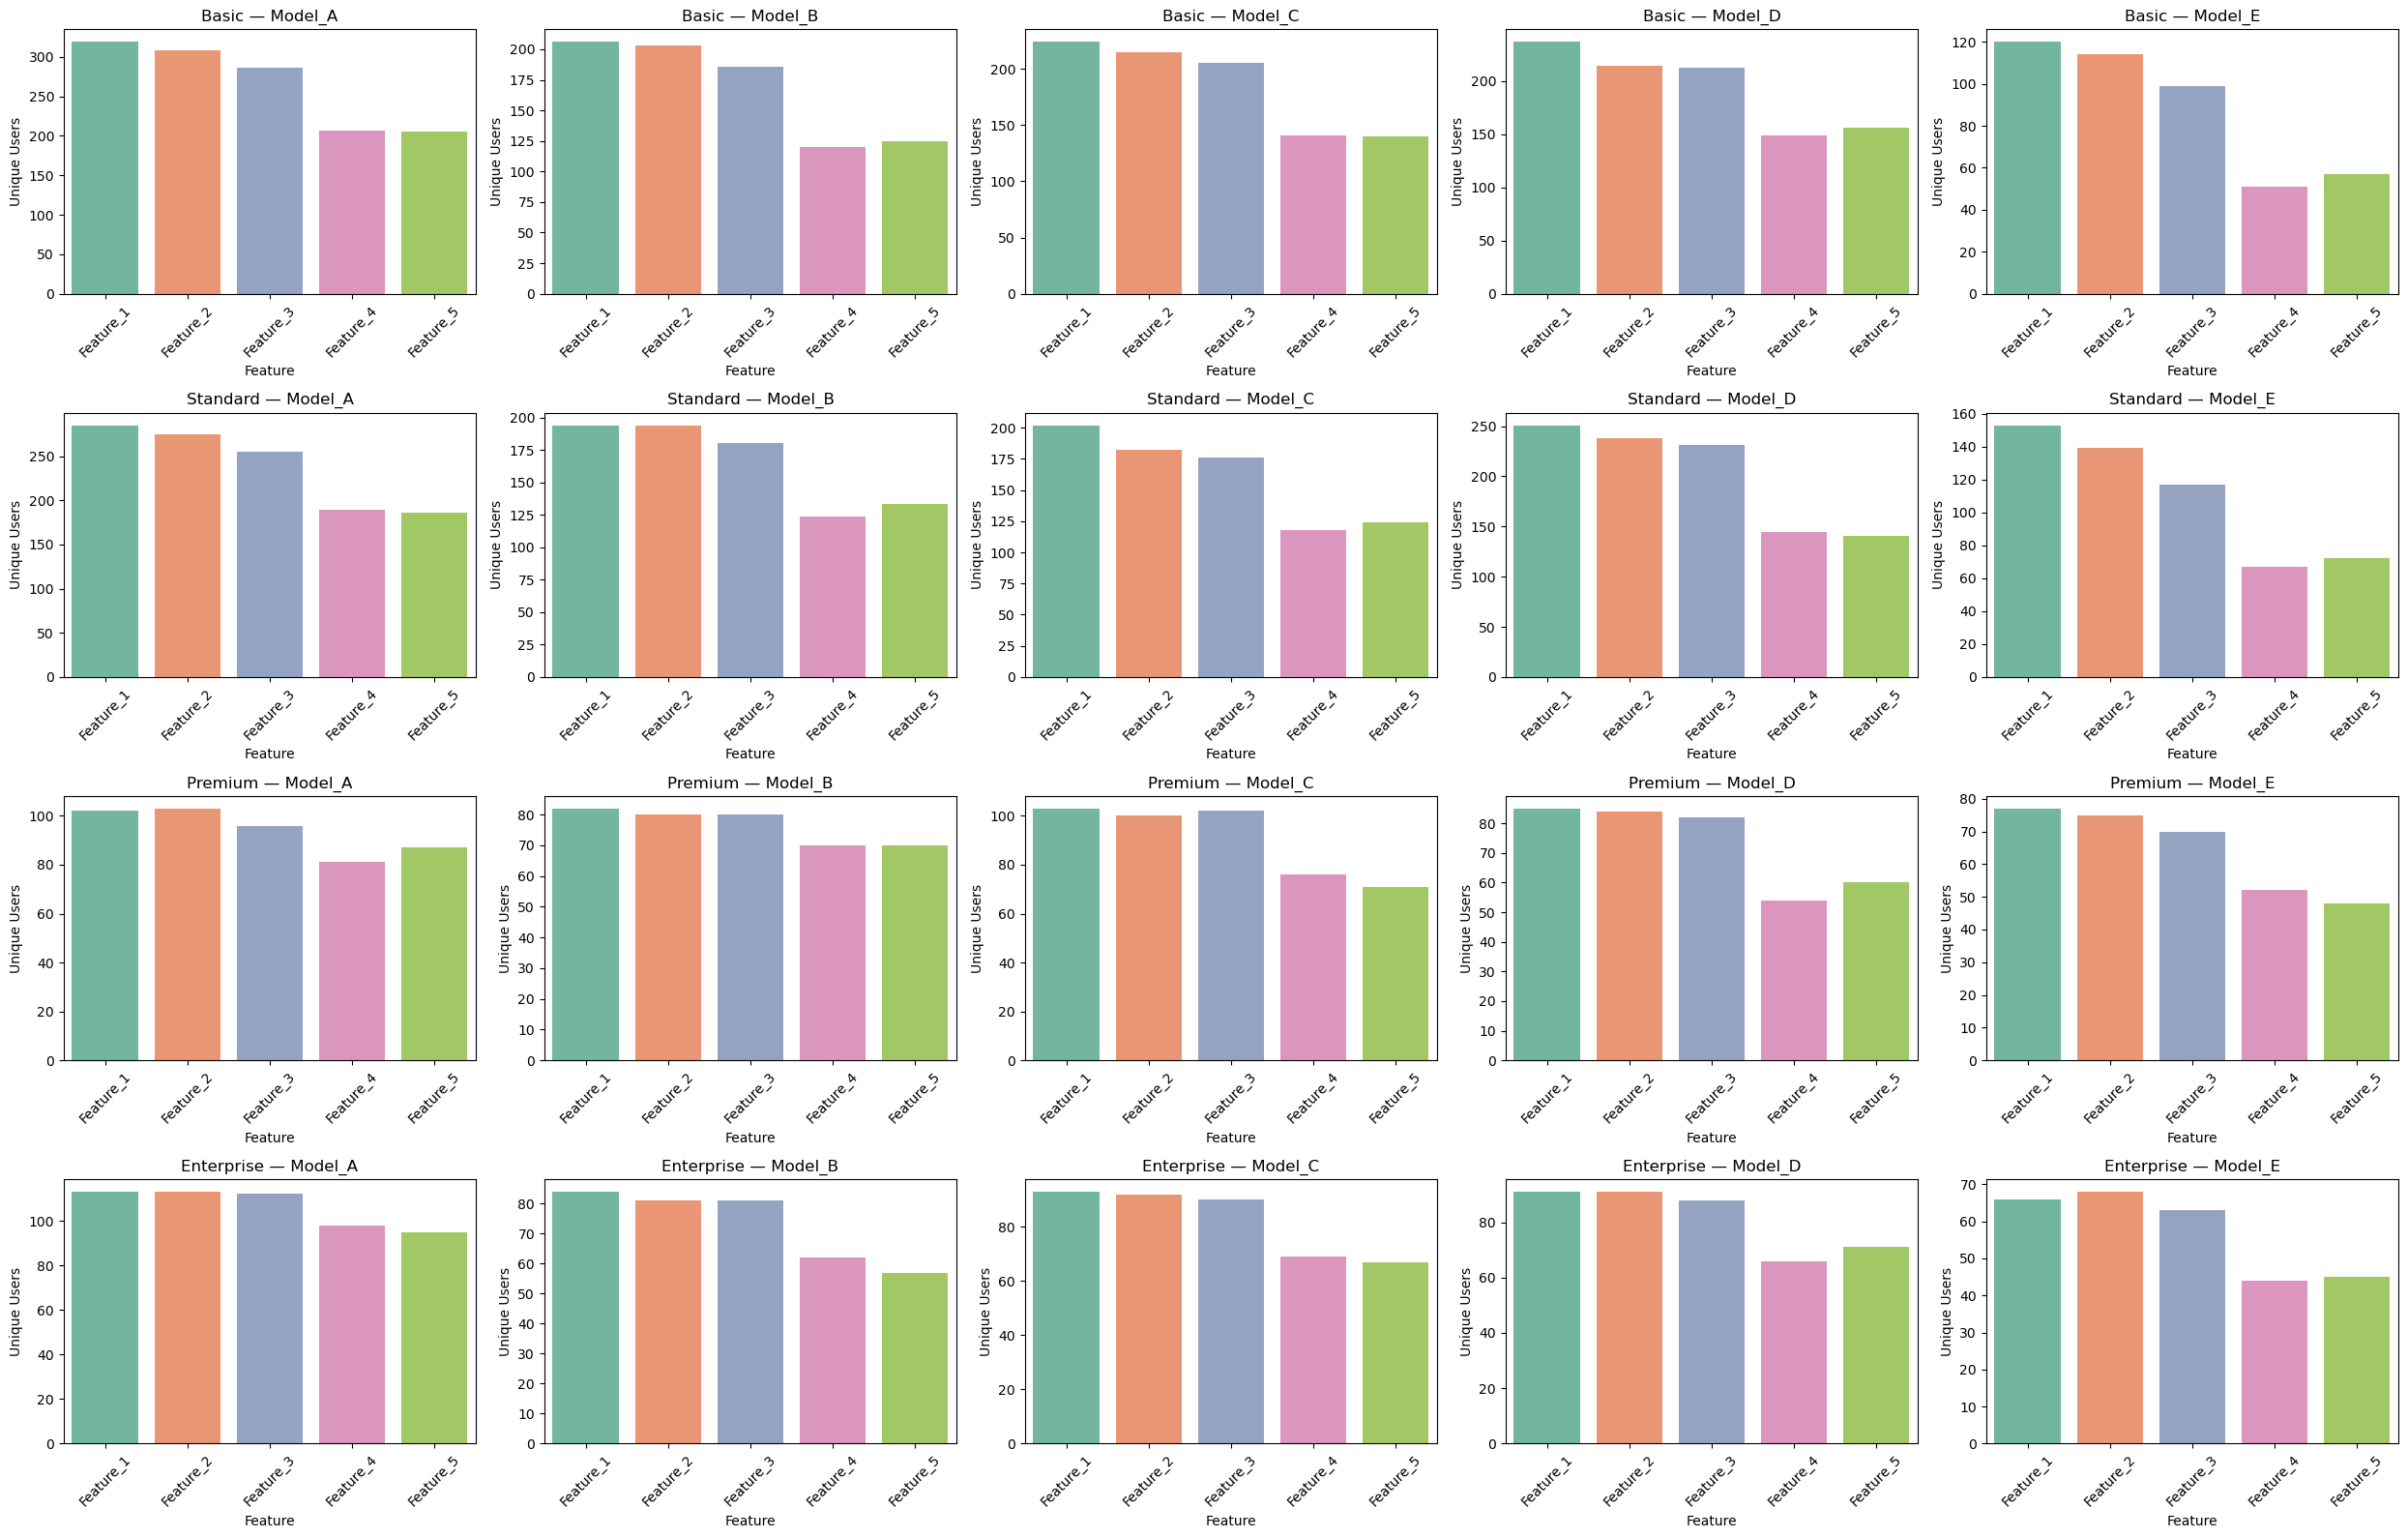

In [84]:
user_licenses = ['Basic', 'Standard', 'Premium', 'Enterprise']
models = sorted(data['model'].unique())
num_licenses = len(user_licenses)  # 4
num_models = len(models)  # 5

# Count unique users per model and feature for each license
model_feature_data = data.groupby(['license', 'model', 'feature'])['uuid'].nunique().reset_index(name='unique_users')

fig, axes = plt.subplots(num_licenses, num_models, figsize=(5*num_models, 4*num_licenses))

for i, user_license in enumerate(user_licenses):
    license_data = model_feature_data[model_feature_data['license'] == user_license]
    
    for j, model in enumerate(models):
        model_data = license_data[license_data['model'] == model]
        
        # Bar plot of features for this model
        sns.barplot(
            data=model_data,
            x='feature',
            y='unique_users',
            ax=axes[i, j],
            palette='Set2'
        )
        
        axes[i, j].set_title(f"{user_license} — {model}")
        axes[i, j].set_xlabel("Feature")
        axes[i, j].set_ylabel("Unique Users")
        axes[i, j].tick_params(axis='x', rotation=45)

# Equalize Y-limits for all plots
# y_max = max(ax.get_ylim()[1] for row in axes for ax in row)
# for row in axes:
#     for ax in row:
#         ax.set_ylim(0, y_max)

plt.tight_layout()
plt.show()

Basicly features 4 an 5 are used less than features 1, 2, 3 all around the board.

## Request price

In [85]:
# Calculate requests price
data['one_request_price'] = data['spent_amount'] / data['requests_cnt']

In [86]:
# Group by license, model, feature and calculate mean and std, looking for dependencies between variables
#cost_efficiency = data.groupby(['license', 'model', 'feature'])['one_request_price'].agg(['min', 'max', 'mean', 'std', 'count']).reset_index()
cost_efficiency = data.groupby(['model'])['one_request_price'].agg(['min', 'max', 'mean', 'std', 'count']).reset_index()
cost_efficiency['max-min'] = cost_efficiency['max'] - cost_efficiency['min']

cost_efficiency.sort_values(by=['model'], ascending=True)

,model,min,max,mean,std,count,max-min
0,Model_A,0.218462,0.519231,0.369166,0.034637,38042,0.300769
1,Model_B,0.224706,0.640000,0.366373,0.034356,23110,0.415294
2,Model_C,0.036000,0.366809,0.189598,0.038462,24433,0.330809
3,Model_D,0.006923,0.387664,0.192177,0.043141,24423,0.380740
4,Model_E,0.021200,0.348696,0.190301,0.039000,12738,0.327496


Looks like price mainly depends just on model type.

Models A and B are more expensive than C, D, E.

A,B cost on average 0.37 per request and C,D,E cost on average around 0.19 per request.

## Analysing activity over time

In [87]:
# Convert day_id to datetime
data['day_id'] = pd.to_datetime(data['day_id'])

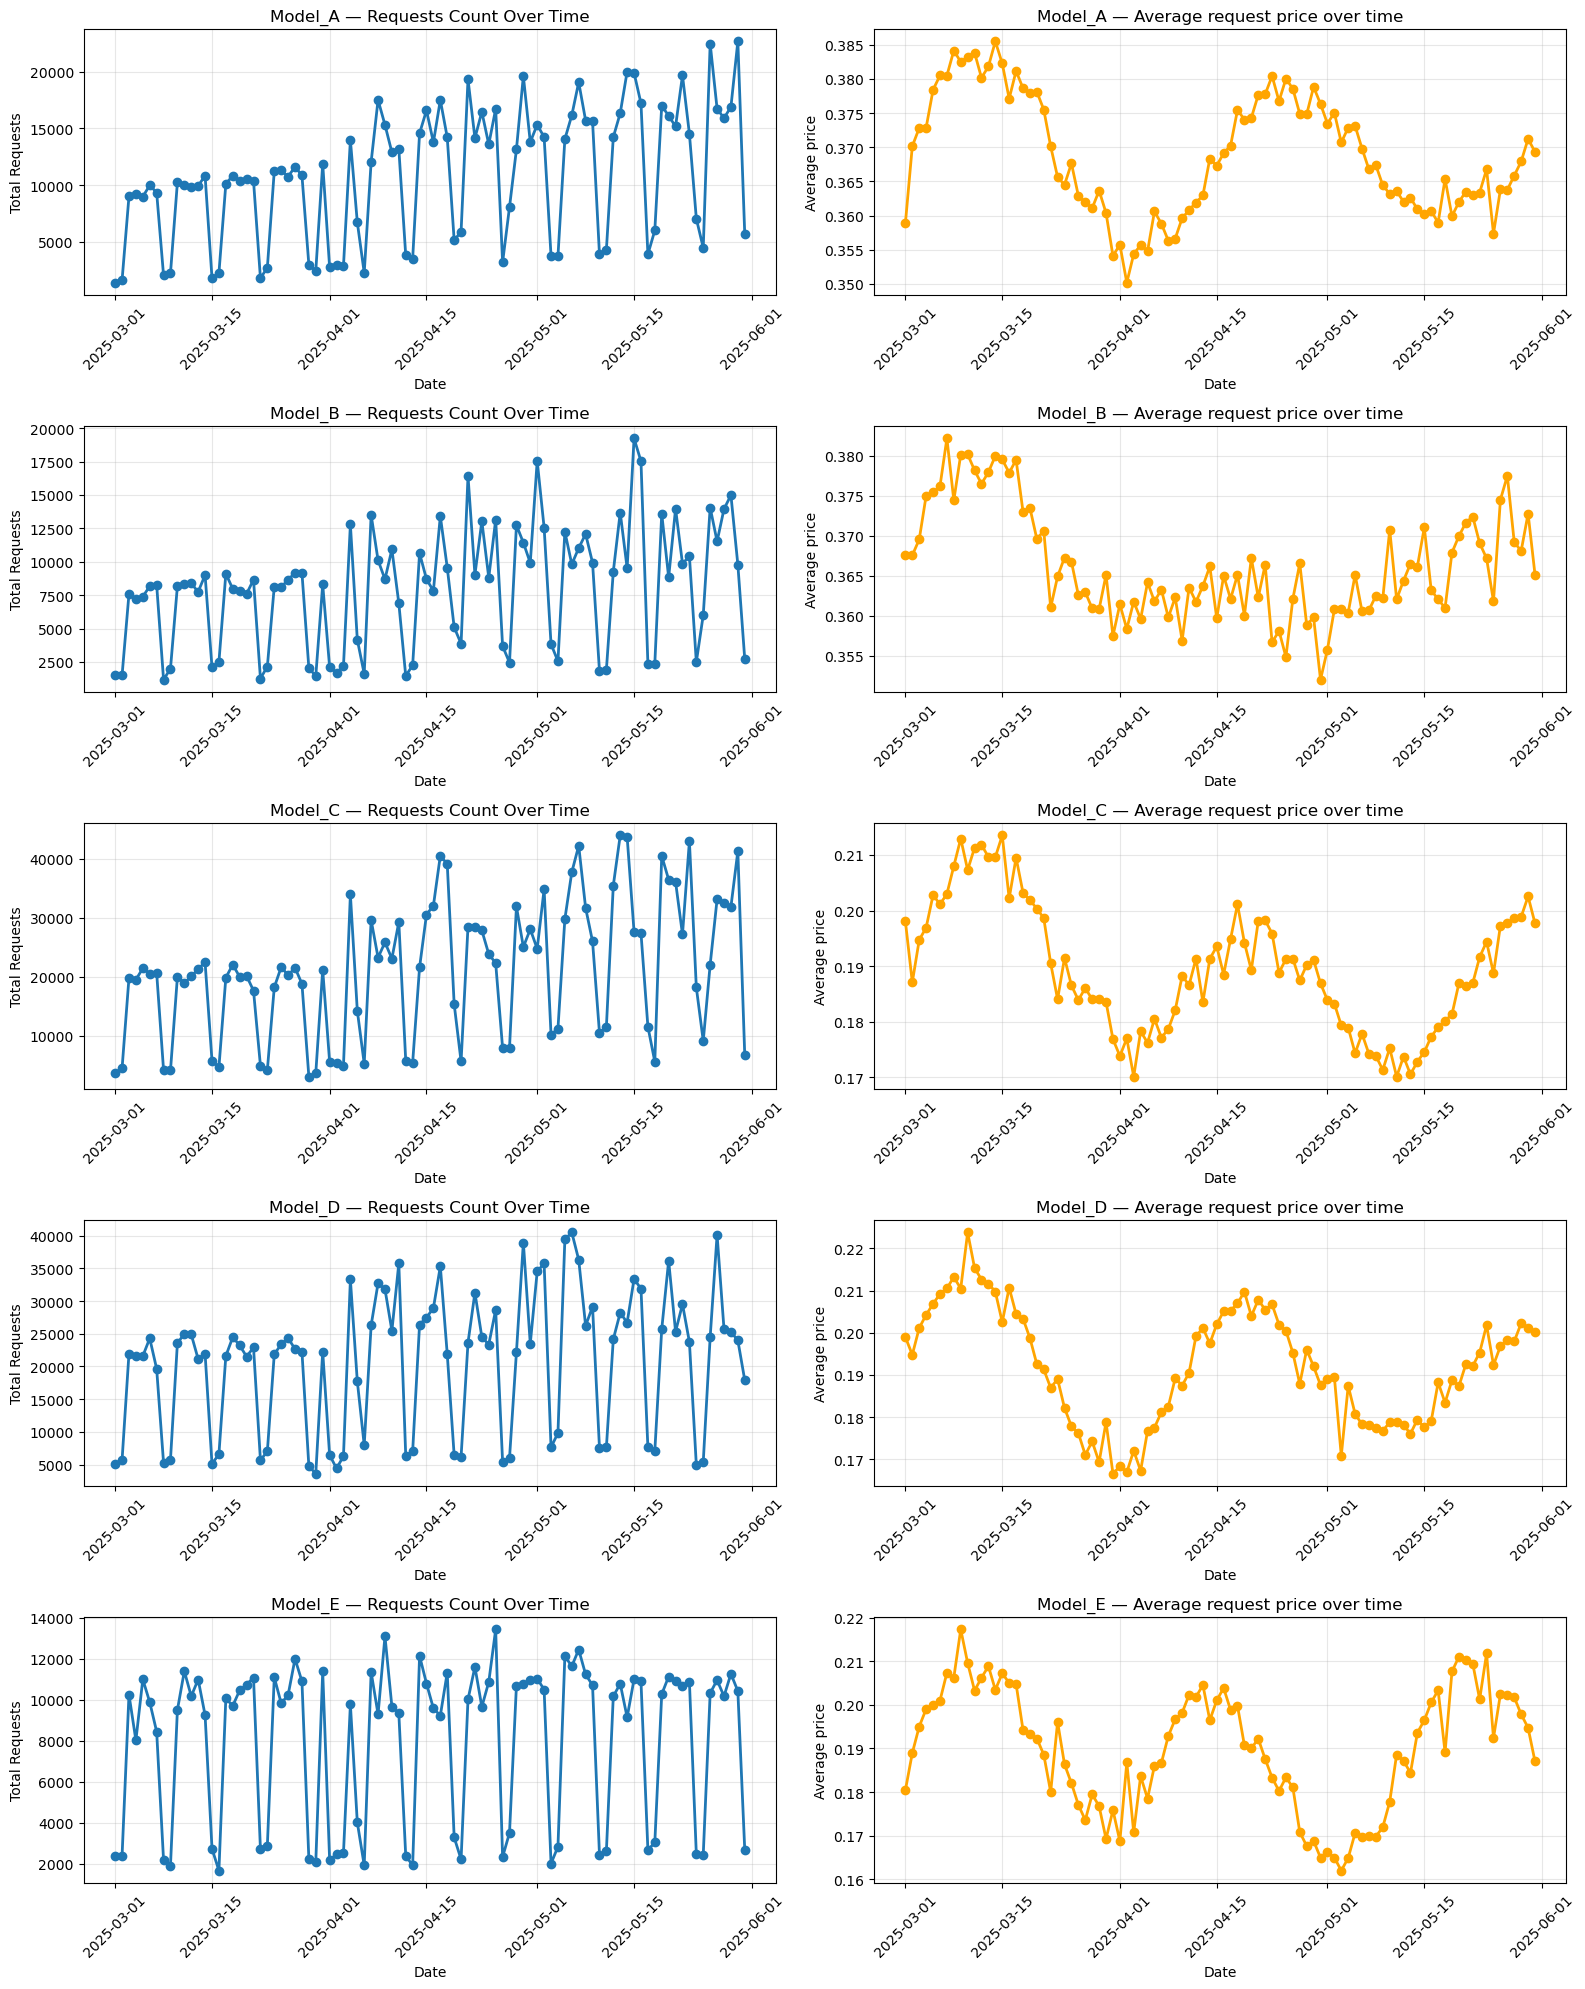

In [88]:
time_series_data = data.groupby(['day_id', 'model']).agg({
    'requests_cnt': 'sum',
    'one_request_price': 'mean'
}).reset_index()

models = sorted(data['model'].unique())
num_models = len(models)

fig, axes = plt.subplots(num_models, 2, figsize=(16, 4*num_models))

for i, model in enumerate(models):
    model_data = time_series_data[time_series_data['model'] == model]
    
    # Left: requests_cnt over time
    axes[i, 0].plot(model_data['day_id'], model_data['requests_cnt'], marker='o', linewidth=2)
    axes[i, 0].set_title(f"{model} — Requests Count Over Time")
    axes[i, 0].set_xlabel("Date")
    axes[i, 0].set_ylabel("Total Requests")
    axes[i, 0].grid(True, alpha=0.3)
    axes[i, 0].tick_params(axis='x', rotation=45)
    
    # Right: one_request_price over time
    axes[i, 1].plot(model_data['day_id'], model_data['one_request_price'], marker='o', linewidth=2, color='orange')
    axes[i, 1].set_title(f"{model} — Average request price over time")
    axes[i, 1].set_xlabel("Date")
    axes[i, 1].set_ylabel("Average price")
    axes[i, 1].grid(True, alpha=0.3)
    axes[i, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Plots look interesting, looks like on some weekdays models are used less (quick guess: its weekends).

Before April all models exluding E were used less, and maybe (for sure model A) they are getting more and more use over time. In next cells I will check my theories, but before that lets check different user licenses over time.

Model E in April had slightly higher peaks than before in March and after in May.

Average request price also looks interesting. Looks like all 5 models have similar price tendencies, maybe except for B, its more chaotic.

Prices rise at the beginning of the month and drop at the end of the month for every of 3 months analysed.

Price for B is looking similar to other at the beginning of March, but then it 'crashes'.

#### Looking for similar trends over time for licenses

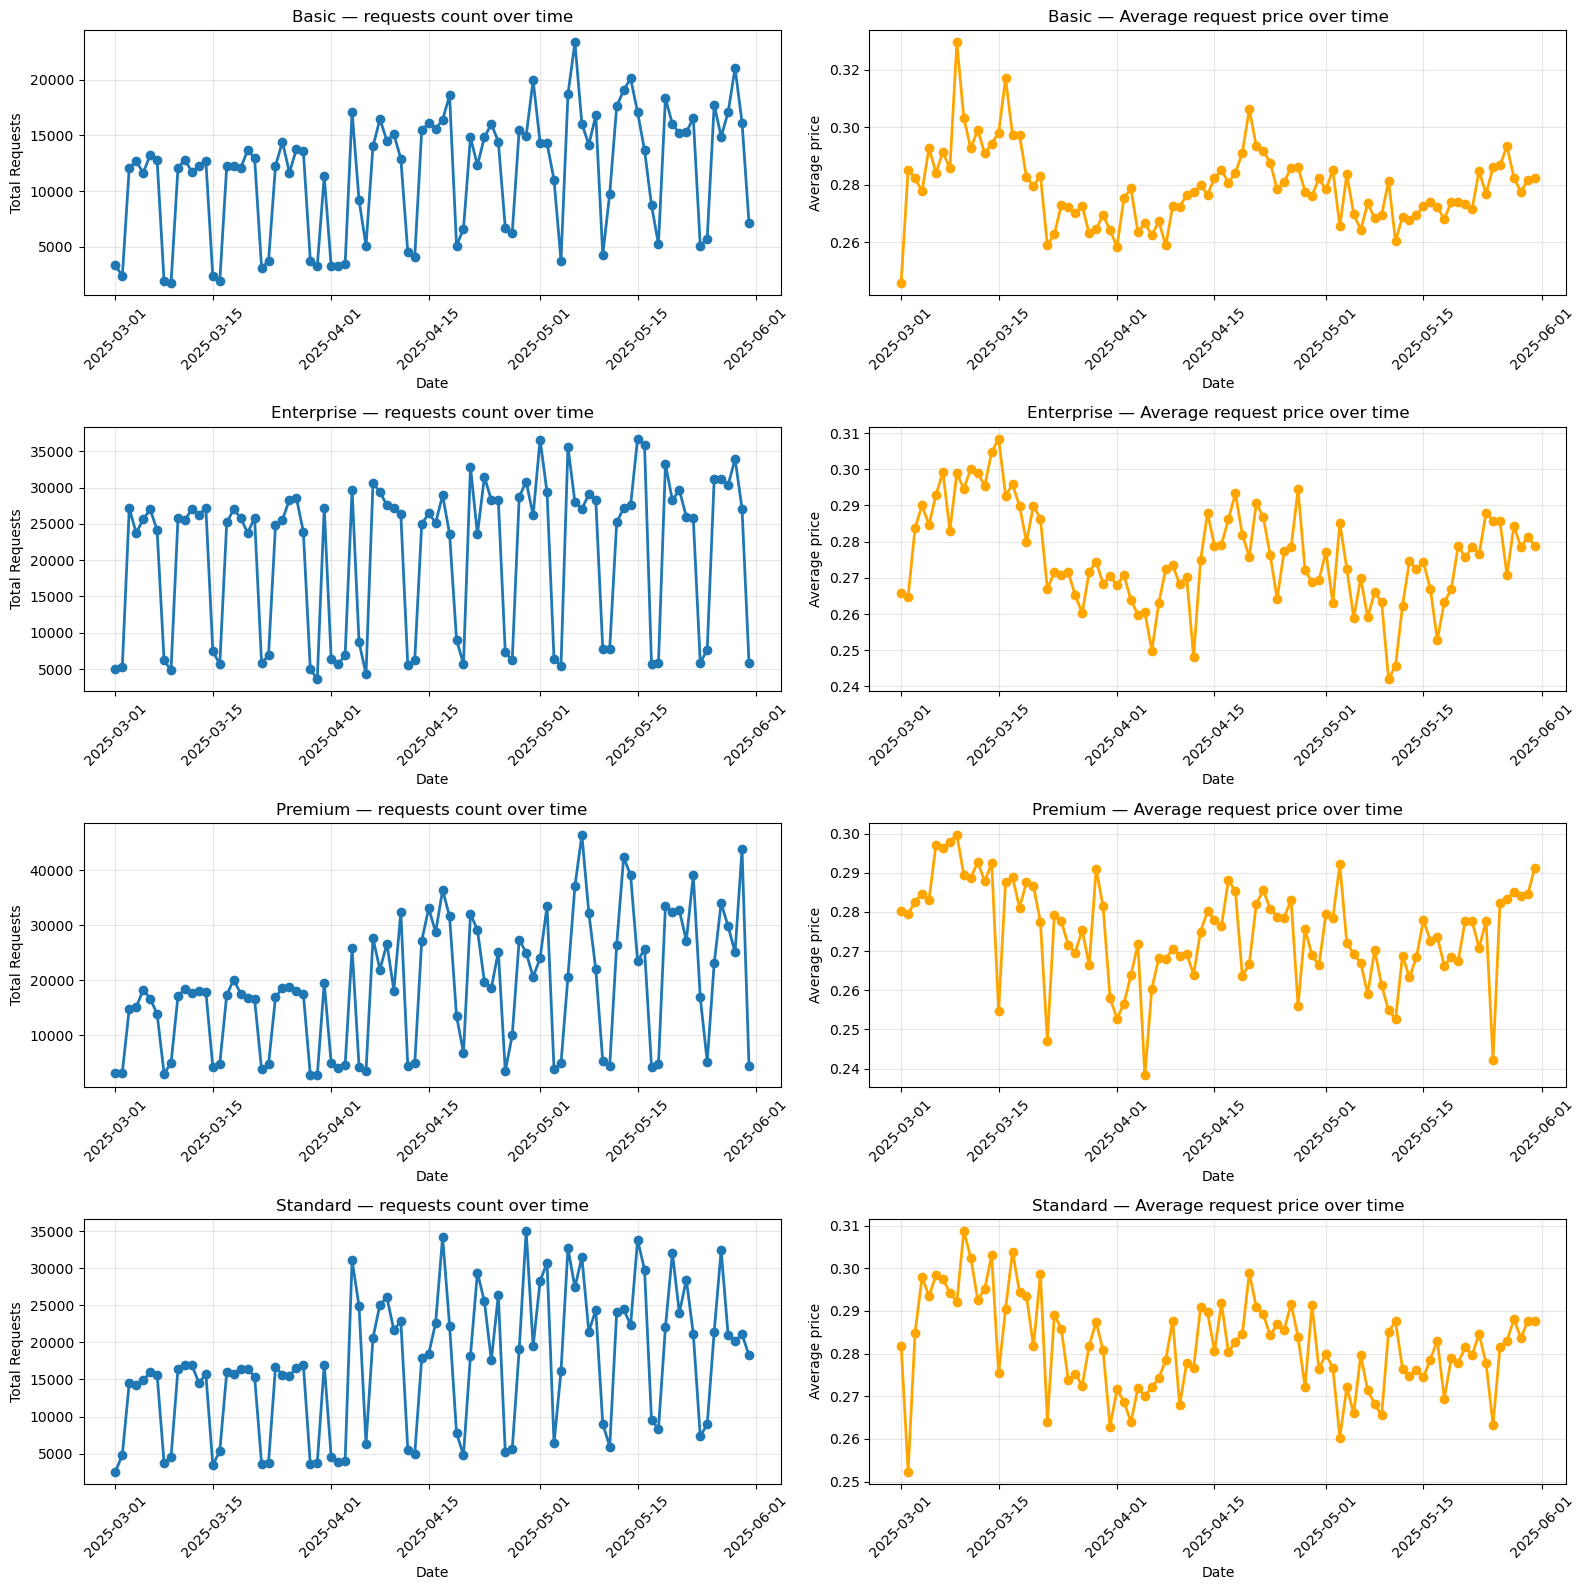

In [89]:
# Group by day and license
time_series_data = data.groupby(['day_id', 'license']).agg({
    'requests_cnt': 'sum',
    'one_request_price': 'mean'
}).reset_index()

licenses = sorted(data['license'].unique())
num_licenses = len(licenses)

fig, axes = plt.subplots(num_licenses, 2, figsize=(16, 4*num_licenses))

for i, license in enumerate(licenses):
    license_data = time_series_data[time_series_data['license'] == license]
    
    # Left: requests_cnt over time
    axes[i, 0].plot(license_data['day_id'], license_data['requests_cnt'], marker='o', linewidth=2)
    axes[i, 0].set_title(f"{license} — requests count over time")
    axes[i, 0].set_xlabel("Date")
    axes[i, 0].set_ylabel("Total Requests")
    axes[i, 0].grid(True, alpha=0.3)
    axes[i, 0].tick_params(axis='x', rotation=45)
    
    # Right: one_request_price over time
    axes[i, 1].plot(license_data['day_id'], license_data['one_request_price'], marker='o', linewidth=2, color='orange')
    axes[i, 1].set_title(f"{license} — Average request price over time")
    axes[i, 1].set_xlabel("Date")
    axes[i, 1].set_ylabel("Average price")
    axes[i, 1].grid(True, alpha=0.3)
    axes[i, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Standard behaves a little more stable than the rest, other than that no new information gained from these plots.

### Grouping by week

In [90]:
data['weekday'] = data['day_id'].apply(lambda x : x.weekday()) # 0-Monday, ..., 6-Sunday
data['week_num'] = data['day_id'].dt.isocalendar().week
data['month'] = data['day_id'].apply(lambda x: x.month)

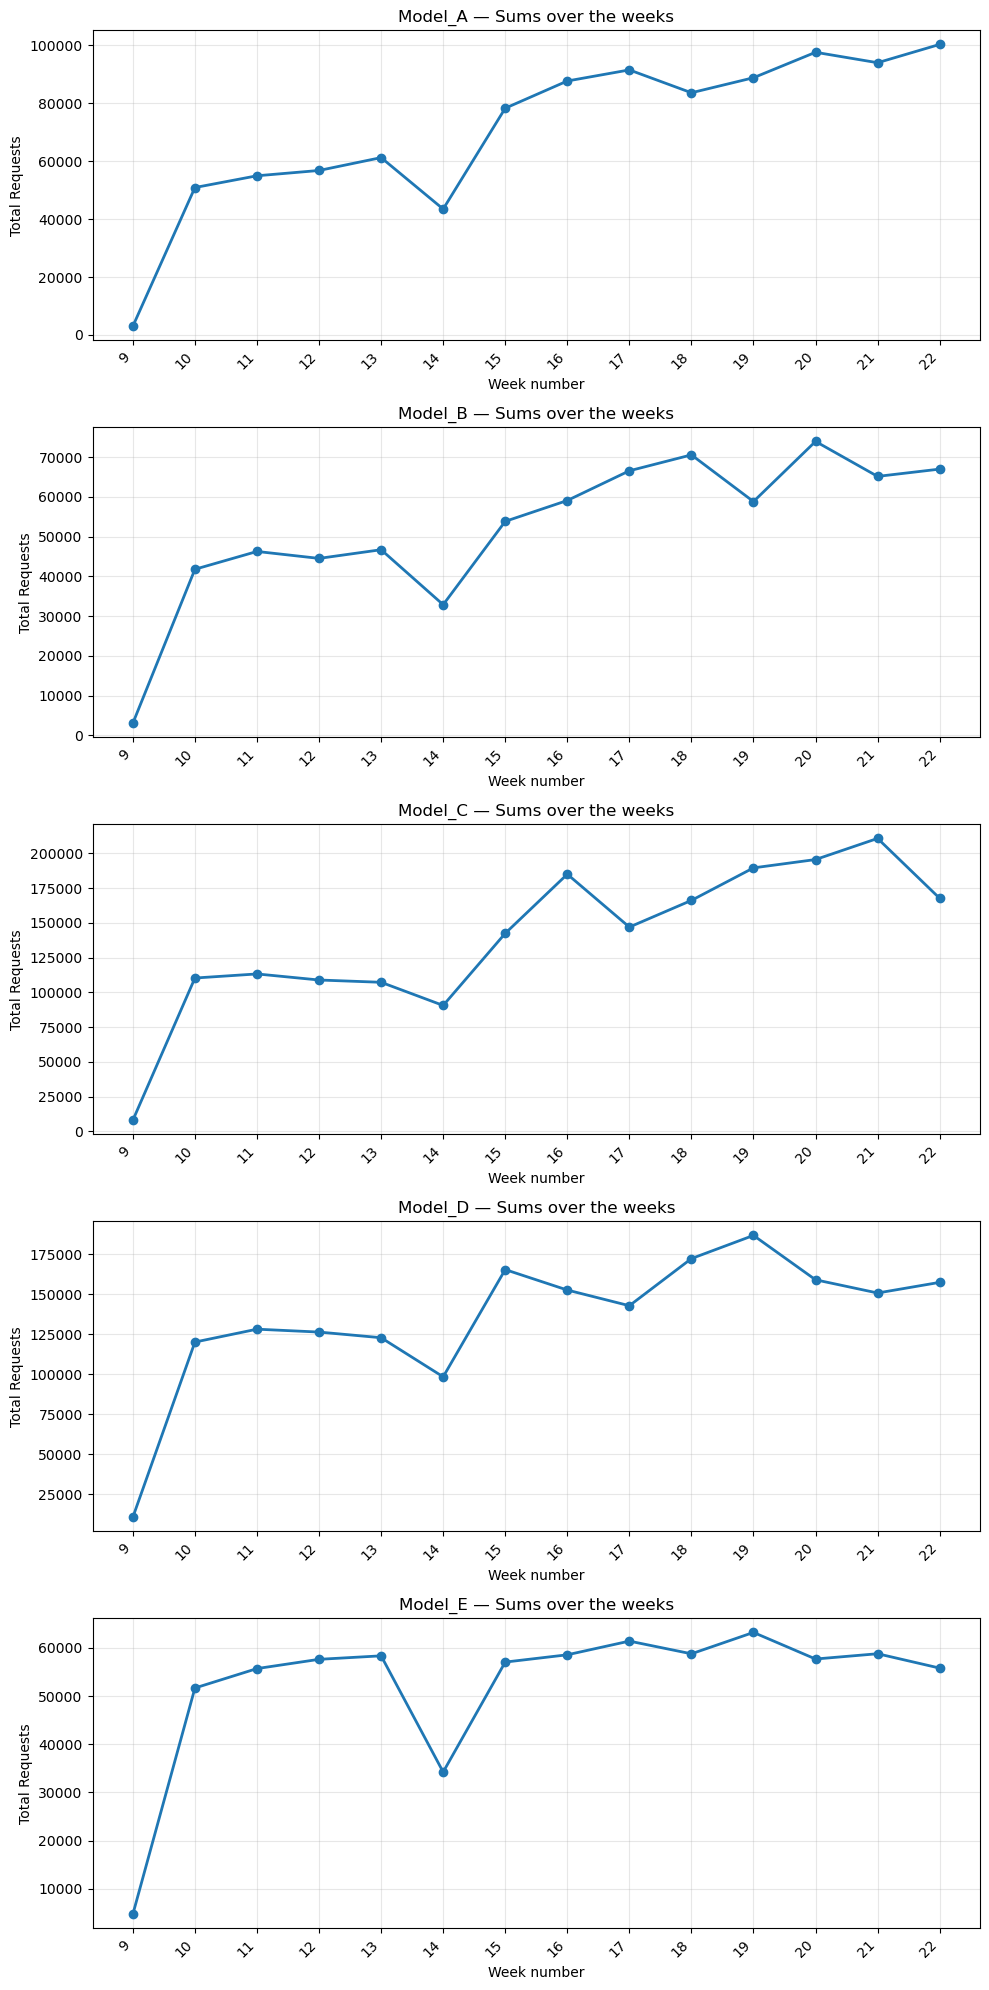

In [91]:
# Group by day and model
time_series_data = data.groupby(['week_num', 'model']).agg({
    'requests_cnt': 'sum'
}).reset_index()

models = sorted(data['model'].unique())
num_models = len(models)

fig, axes = plt.subplots(num_models, 1, figsize=(10, 4*num_models))

for i, model in enumerate(models):
    model_data = time_series_data[time_series_data['model'] == model]
    
    axes[i].plot(model_data['week_num'], model_data['requests_cnt'], marker='o', linewidth=2)
    axes[i].set_title(f"{model} — Sums over the weeks")
    axes[i].set_xlabel("Week number")
    axes[i].set_ylabel("Total Requests")
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)
    
    # Show all x-axis ticks
    axes[i].set_xticks(model_data['week_num'])
    axes[i].set_xticklabels(model_data['week_num'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

It's not worth to analyse first week no. 9 because it's not full 7 days.

Indeed all models get more requests over time, except for model E which is stable in terms of requests recieved.

What wasn't that clearly visible on previous plots, is that there was significantly less requests in 14th week (beginning of April).

In [92]:
data[data['week_num']==14]['day_id'].drop_duplicates().sort_values().reset_index(drop=True)

0   2025-03-31
1   2025-04-01
2   2025-04-02
3   2025-04-03
4   2025-04-04
5   2025-04-05
6   2025-04-06
Name: day_id, dtype: datetime64[ns]

## Analysing users activity over different days of the week

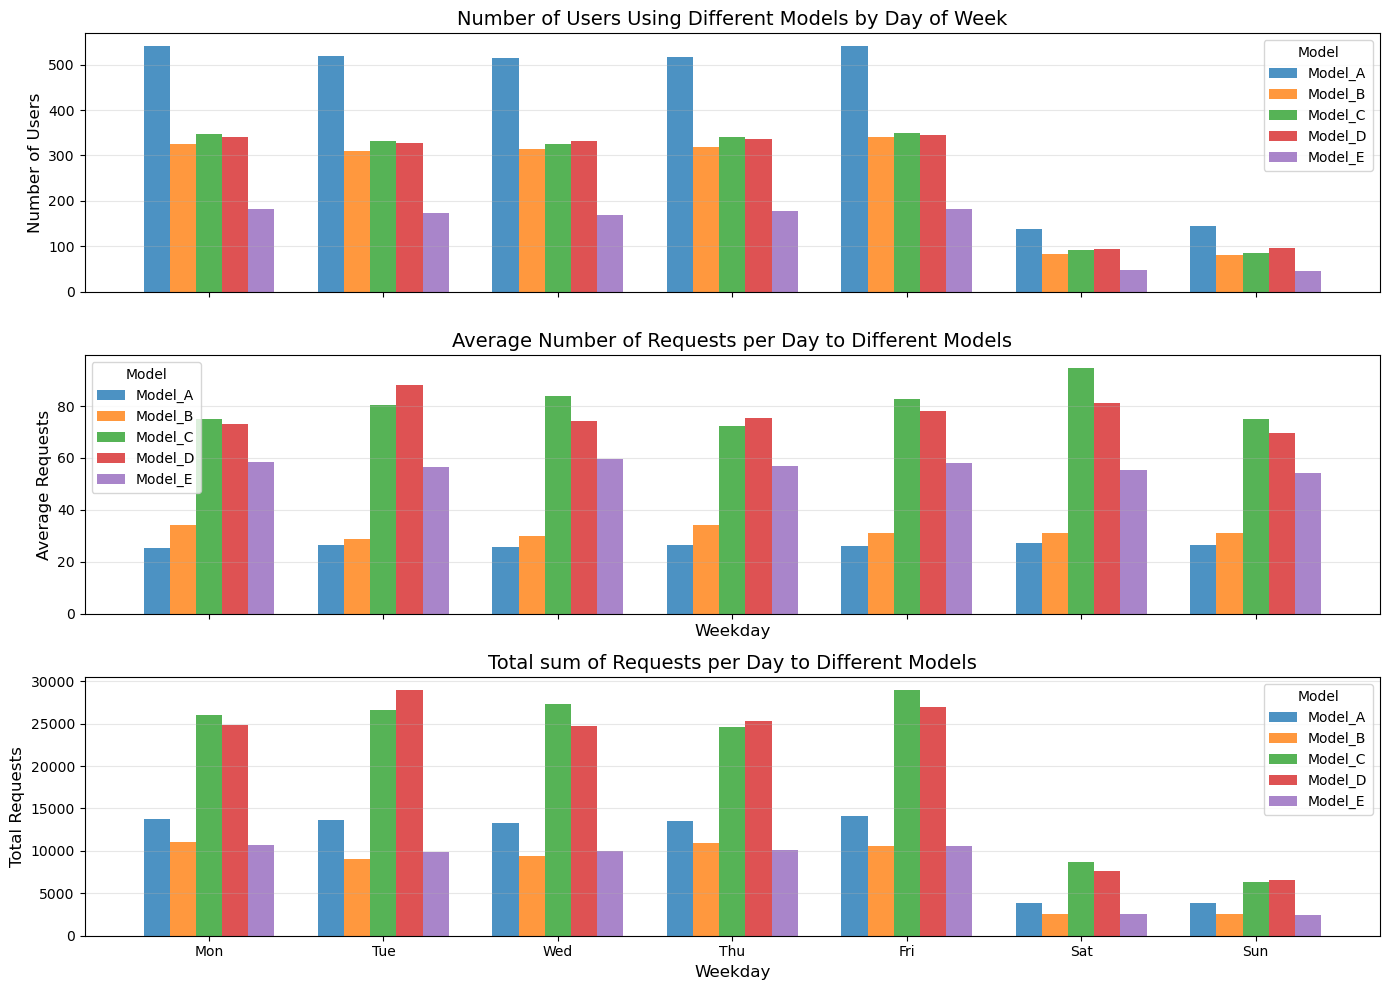

In [ ]:
# how many times each weekday appears in the dataset to normalise values
weekday_counts = data.drop_duplicates('day_id')['weekday'].value_counts().to_dict()

# number of users
weekday_count = (
    data.groupby(['weekday', 'model'])
    .agg({'uuid': 'count'})
    .reset_index()
    .rename(columns={'uuid': 'user_count'})
)
weekday_count['user_count'] = weekday_count.apply(
    lambda row: row['user_count'] / weekday_counts[row['weekday']],
    axis=1
)

# average requests per day
weekday_avg = (
    data.groupby(['weekday', 'model'])
    .agg({'requests_cnt': 'mean'})
    .reset_index()
)

# sum of requests per day
weekday_total_sum = (
    data.groupby(['weekday', 'model'])
    .agg({'requests_cnt': 'sum'})
    .reset_index()
)
weekday_total_sum['requests_cnt'] = weekday_total_sum.apply(
    lambda row: row['requests_cnt'] / weekday_counts[row['weekday']],
    axis=1
)

models = sorted(data['model'].unique())
x = np.arange(7)
width = 0.15

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
palette = plt.cm.tab10.colors

for i, model in enumerate(models):
    model_data = weekday_count[weekday_count['model'] == model]
    offset = width * (i - len(models)/2 + 0.5)
    axes[0].bar(x + offset, model_data['user_count'], width, label=model, alpha=0.8, color=palette[i])

axes[0].set_ylabel('Number of Users', fontsize=12)
axes[0].set_title('Number of Users Using Different Models by Day of Week', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[0].legend(title='Model')
axes[0].grid(True, alpha=0.3, axis='y')

for i, model in enumerate(models):
    model_data = weekday_avg[weekday_avg['model'] == model]
    offset = width * (i - len(models)/2 + 0.5)
    axes[1].bar(x + offset, model_data['requests_cnt'], width, label=model, alpha=0.8, color=palette[i])

axes[1].set_xlabel('Weekday', fontsize=12)
axes[1].set_ylabel('Average Requests', fontsize=12)
axes[1].set_title('Average Number of Requests per Day to Different Models', fontsize=14)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[1].legend(title='Model')
axes[1].grid(True, alpha=0.3, axis='y')

for i, model in enumerate(models):
    model_data = weekday_total_sum[weekday_total_sum['model'] == model]
    offset = width * (i - len(models)/2 + 0.5)
    axes[2].bar(x + offset, model_data['requests_cnt'], width, label=model, alpha=0.8, color=palette[i])

axes[2].set_xlabel('Weekday', fontsize=12)
axes[2].set_ylabel('Total Requests', fontsize=12)
axes[2].set_title('Total sum of Requests per Day to Different Models', fontsize=14)
axes[2].set_xticks(x)
axes[2].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[2].legend(title='Model')
axes[2].grid(True, alpha=0.3, axis='y')


plt.tight_layout()
plt.show()


Activity is definetly lower on weekends, but model C is reciving slightly more requests on average on Saturadays, this might be a fluke though as the difference is not that big. What we can see for sure is that the average number of requests is not changing that much during the whole week.

We can also notice that even though model A has more unique users, C, D and E have more requests send on average during one day, and because of that it's actually C and D that have the highest number of requests total on average for every day of the week. 

#### Lets make similar plots for license during the week

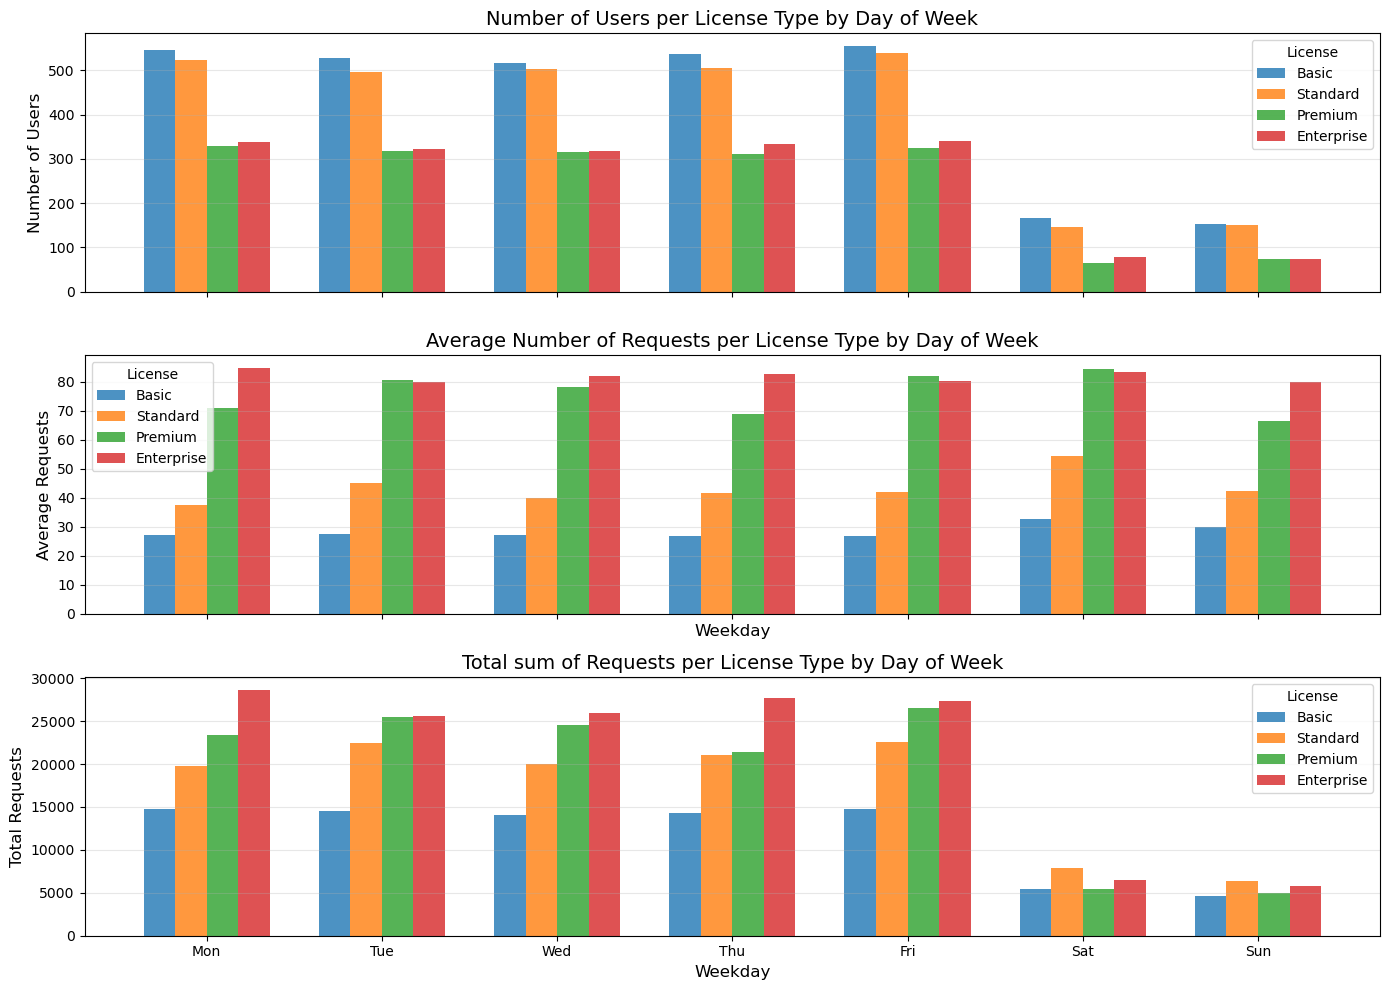

In [106]:
weekday_counts = data.drop_duplicates('day_id')['weekday'].value_counts().to_dict()

# Count of users per license and weekday
weekday_license_users = (
    data.groupby(['weekday', 'license'])['uuid']
    .count()
    .reset_index(name='user_count')
)
weekday_license_users['user_count'] = weekday_license_users.apply(
    lambda row: row['user_count'] / weekday_counts[row['weekday']],
    axis=1
)

# Average requests per license and weekday
weekday_license_avg = (
    data.groupby(['weekday', 'license'])['requests_cnt']
    .mean()
    .reset_index(name='avg_requests')
)

# Sum of requests per license and weekday
weekday_license_total_sum = (
    data.groupby(['weekday', 'license'])['requests_cnt']
    .sum()
    .reset_index(name='total_requests')
)
weekday_license_total_sum['total_requests'] = weekday_license_total_sum.apply(
    lambda row: row['total_requests'] / weekday_counts[row['weekday']],
    axis=1
)

licenses = ['Basic', 'Standard', 'Premium', 'Enterprise']
x = np.arange(7)
width = 0.18
palette = plt.cm.tab10.colors

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for i, license_name in enumerate(licenses):
    subset = weekday_license_users[weekday_license_users['license'] == license_name]
    offset = width * (i - len(licenses)/2 + 0.5)
    axes[0].bar(x + offset, subset['user_count'], width, label=license_name, alpha=0.8, color=palette[i])

axes[0].set_ylabel('Number of Users', fontsize=12)
axes[0].set_title('Number of Users per License Type by Day of Week', fontsize=14)
axes[0].legend(title='License')
axes[0].grid(True, alpha=0.3, axis='y')

for i, license_name in enumerate(licenses):
    subset = weekday_license_avg[weekday_license_avg['license'] == license_name]
    offset = width * (i - len(licenses)/2 + 0.5)
    axes[1].bar(x + offset, subset['avg_requests'], width, label=license_name, alpha=0.8, color=palette[i])

axes[1].set_xlabel('Weekday', fontsize=12)
axes[1].set_ylabel('Average Requests', fontsize=12)
axes[1].set_title('Average Number of Requests per License Type by Day of Week', fontsize=14)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[1].legend(title='License')
axes[1].grid(True, alpha=0.3, axis='y')

for i, license_name in enumerate(licenses):
    subset = weekday_license_total_sum[weekday_license_total_sum['license'] == license_name]
    offset = width * (i - len(licenses)/2 + 0.5)
    axes[2].bar(x + offset, subset['total_requests'], width, label=license_name, alpha=0.8, color=palette[i])

axes[2].set_xlabel('Weekday', fontsize=12)
axes[2].set_ylabel('Total Requests', fontsize=12)
axes[2].set_title('Total sum of Requests per License Type by Day of Week', fontsize=14)
axes[2].set_xticks(x)
axes[2].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[2].legend(title='License')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Similar story to the previous plot, it seems like Premium and Enterprise users are the ones sending on average more requests and because of that they send more requests in total than Basic and Standard users.

But it shows that actvity during the middle of the week or weekend doesn't depend on license.

# Part 2 : Supervised Machine Learning

Idea: Let's try to predict users license based on their behaviour. Maybe we could use that to propose Premium license to Basic users? (earn more?)

### Imports + Preprocessing

We can run the code independently from here.

In [38]:
import pandas as pd
import numpy as np


import warnings
warnings.filterwarnings("ignore")

In [39]:
data = pd.read_csv("da_internship_task_dataset.csv")
data.head()

,uuid,day_id,license,model,feature,requests_cnt,spent_amount
0,user_920,2025-05-01,Premium,Model_A,Feature_1,44.0,16.38
1,user_717,2025-03-04,Premium,Model_B,Feature_2,72.0,27.92
2,user_610,2025-05-08,Premium,Model_A,Feature_2,27.0,9.87
3,user_94,2025-03-11,Basic,Model_D,Feature_1,76.0,14.67
4,user_920,2025-05-14,Premium,Model_E,Feature_3,47.0,9.88


In [40]:
data['one_request_price'] = data['spent_amount'] / data['requests_cnt']
data['day_id'] = pd.to_datetime(data['day_id'])
data['weekday'] = data['day_id'].apply(lambda x : x.weekday()) # 0-Monday, ..., 6-Sunday
# data['week_num'] = data['day_id'].dt.isocalendar().week
# data['month'] = data['day_id'].apply(lambda x: x.month)

In [41]:
data.head()

,uuid,day_id,license,model,feature,requests_cnt,spent_amount,one_request_price,weekday
0,user_920,2025-05-01,Premium,Model_A,Feature_1,44.0,16.38,0.372273,3
1,user_717,2025-03-04,Premium,Model_B,Feature_2,72.0,27.92,0.387778,1
2,user_610,2025-05-08,Premium,Model_A,Feature_2,27.0,9.87,0.365556,3
3,user_94,2025-03-11,Basic,Model_D,Feature_1,76.0,14.67,0.193026,1
4,user_920,2025-05-14,Premium,Model_E,Feature_3,47.0,9.88,0.210213,2


OneHotEncoding because I want to sum requests for each combination. If I were to do clustering I would also onehotencode licenses but separately from model and features.

In [42]:
from sklearn.preprocessing import OneHotEncoder
data['model_feature'] = data['model'] + data['feature']

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = ohe.fit_transform(data[['weekday', 'model_feature']])

encoded_df = pd.DataFrame(
    encoded,
    columns=ohe.get_feature_names_out(['weekday', 'model_feature']),
    index=data.index
)

# Concatenate with original data
data = pd.concat([data, encoded_df], axis=1)
data = data.drop(columns = ['day_id', 'weekday', 'model', 'feature', 'model_feature'])

model_feature_cols = [c for c in data.columns if c.startswith('model_feature_')]
# Replace 1s with requests_cnt values
data[model_feature_cols] = data[model_feature_cols].multiply(data['requests_cnt'], axis=0)

data.head()

,uuid,license,requests_cnt,spent_amount,one_request_price,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,...,model_feature_Model_DFeature_1,model_feature_Model_DFeature_2,model_feature_Model_DFeature_3,model_feature_Model_DFeature_4,model_feature_Model_DFeature_5,model_feature_Model_EFeature_1,model_feature_Model_EFeature_2,model_feature_Model_EFeature_3,model_feature_Model_EFeature_4,model_feature_Model_EFeature_5
0,user_920,Premium,44.0,16.38,0.372273,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,user_717,Premium,72.0,27.92,0.387778,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,user_610,Premium,27.0,9.87,0.365556,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,user_94,Basic,76.0,14.67,0.193026,0.0,1.0,0.0,0.0,0.0,...,76.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,user_920,Premium,47.0,9.88,0.210213,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0


In [43]:
def most_frequent(x):
    return x.mode().iloc[0] if not x.mode().empty else np.nan

agg_dict = {
    'license': most_frequent, # had to decide which model for each user to choose, so I went with mode.
    'one_request_price': 'mean' # price for request doesn't change that much so I will just calculate mean.
    # I remember about the difference between the models, but here the informaation is already in number of requests for each model.
}

# The rest of columns are meant to be summed, so we will get an information about users activity.
sum_cols = [c for c in data.columns 
             if c not in ['uuid', 'license', 'one_request_price']]

for c in sum_cols:
    agg_dict[c] = 'sum'
agg_dict
# Perform the aggregation
data = data.groupby('uuid').agg(agg_dict).reset_index()

In [44]:
data['license'] = data['license'].map({'Basic': 0, 'Standard': 1, 'Premium': 2, 'Enterprise': 3})
#data['license'] = data['license'].map({'Basic': 0, 'Standard': 0, 'Premium': 1, 'Enterprise': 1}) # similarities

data.head()

,uuid,license,one_request_price,requests_cnt,spent_amount,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,...,model_feature_Model_DFeature_1,model_feature_Model_DFeature_2,model_feature_Model_DFeature_3,model_feature_Model_DFeature_4,model_feature_Model_DFeature_5,model_feature_Model_EFeature_1,model_feature_Model_EFeature_2,model_feature_Model_EFeature_3,model_feature_Model_EFeature_4,model_feature_Model_EFeature_5
0,user_1,2,0.195113,7917.0,1538.96,21.0,21.0,13.0,28.0,15.0,...,552.0,83.0,104.0,0.0,0.0,2915.0,2260.0,1061.0,557.0,385.0
1,user_10,1,0.214034,4260.0,843.37,19.0,15.0,23.0,13.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,user_100,2,0.339816,3628.0,1128.27,18.0,17.0,18.0,17.0,17.0,...,787.0,229.0,264.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,user_101,1,0.345212,1880.0,624.96,14.0,16.0,11.0,8.0,23.0,...,213.0,90.0,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,user_102,0,0.198589,3346.0,671.40,22.0,18.0,12.0,17.0,17.0,...,1211.0,1020.0,500.0,176.0,68.0,0.0,0.0,0.0,0.0,0.0


In [45]:
user_data = data[['uuid']]

X = data.drop(columns= ['uuid', 'license'])
y = data['license']

In [46]:
X.columns

Index(['one_request_price', 'requests_cnt', 'spent_amount', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'model_feature_Model_AFeature_1',
       'model_feature_Model_AFeature_2', 'model_feature_Model_AFeature_3',
       'model_feature_Model_AFeature_4', 'model_feature_Model_AFeature_5',
       'model_feature_Model_BFeature_1', 'model_feature_Model_BFeature_2',
       'model_feature_Model_BFeature_3', 'model_feature_Model_BFeature_4',
       'model_feature_Model_BFeature_5', 'model_feature_Model_CFeature_1',
       'model_feature_Model_CFeature_2', 'model_feature_Model_CFeature_3',
       'model_feature_Model_CFeature_4', 'model_feature_Model_CFeature_5',
       'model_feature_Model_DFeature_1', 'model_feature_Model_DFeature_2',
       'model_feature_Model_DFeature_3', 'model_feature_Model_DFeature_4',
       'model_feature_Model_DFeature_5', 'model_feature_Model_EFeature_1',
       'model_feature_Model_EFeature_2', 'model_fea

### Predicting license based on user behaviour

In [47]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

#X = X.drop(columns=['spent_amount', 'requests_cnt']) #removing these makes its harder for model to predict, its more interesting

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(n_estimators = 150, use_label_encoder=False, random_state=42) 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)


print("AUC:   ", roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))
print('Accuracy:  ', accuracy_score(y_test, y_pred))

AUC:    0.9659573742830232
Accuracy:   0.8342245989304813


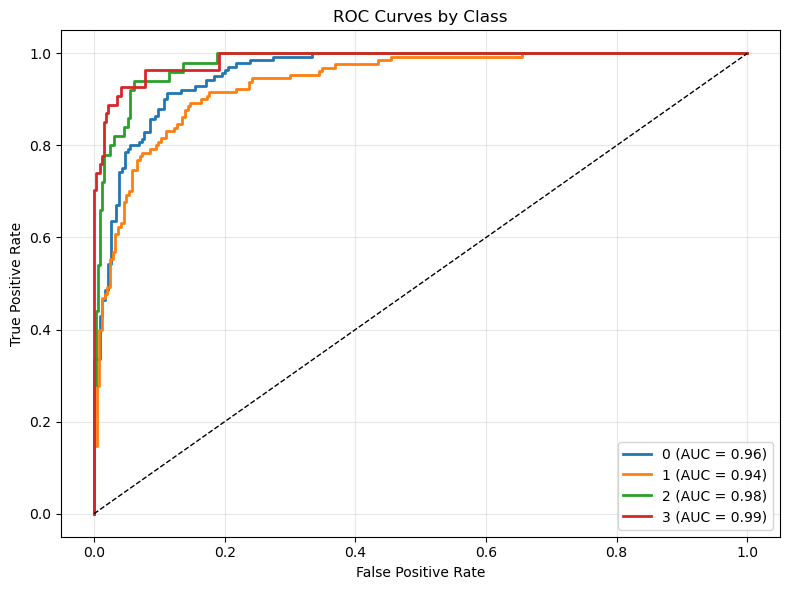

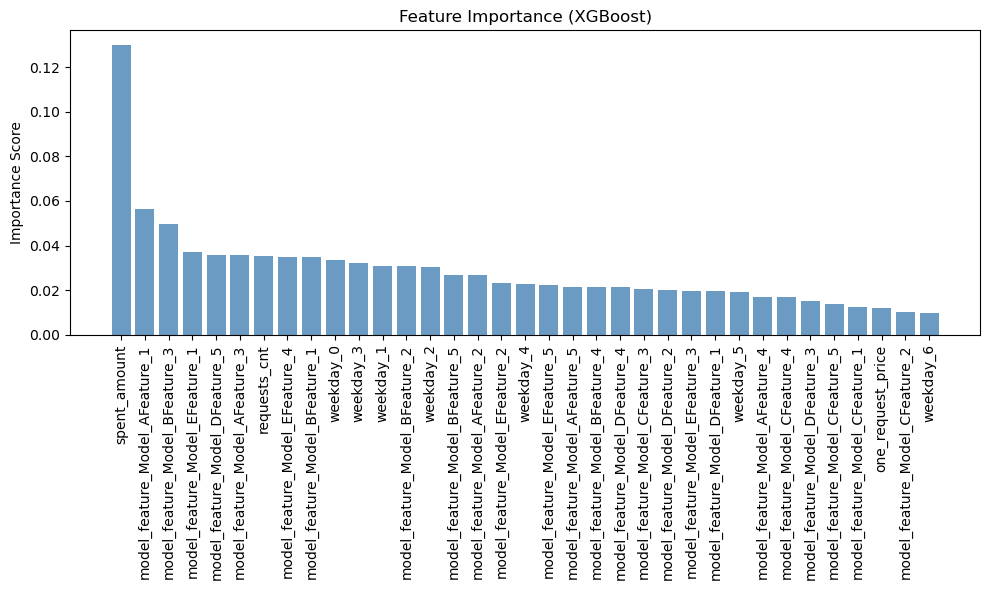

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score


classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    auc_score = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Class')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


importance = model.feature_importances_
features = X.columns if isinstance(X, pd.DataFrame) else [f'f{i}' for i in range(len(importance))]

sorted_idx = np.argsort(importance)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(len(importance)), importance[sorted_idx], color='steelblue', alpha=0.8)
plt.xticks(range(len(importance)), np.array(features)[sorted_idx], rotation=90)
plt.title('Feature Importance (XGBoost)')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

In [49]:
# Get predictions for all data (already aggregated by user)
all_predictions_proba = model.predict_proba(X)
all_predictions = model.predict(X)

# Create dataframe with uuid, actual license, and predicted probabilities
user_predictions = pd.DataFrame({
    'uuid': user_data['uuid'],
    'actual_license': y,
    'predicted_license': all_predictions,
    'pred_Basic': all_predictions_proba[:, 0] * 100,
    'pred_Standard': all_predictions_proba[:, 1] * 100,
    'pred_Premium': all_predictions_proba[:, 2] * 100,
    'pred_Enterprise': all_predictions_proba[:, 3] * 100
})

# Map license numbers back to names
license_map = {0: 'Basic', 1: 'Standard', 2: 'Premium', 3: 'Enterprise'}
user_predictions['actual_license'] = user_predictions['actual_license'].map(license_map)
user_predictions['predicted_license'] = user_predictions['predicted_license'].map(license_map)

# Add max probability column
user_predictions['confidence'] = user_predictions[['pred_Basic', 'pred_Standard', 'pred_Premium', 'pred_Enterprise']].max(axis=1)

user_predictions.sort_values('confidence', ascending=True).head(10)

,uuid,actual_license,predicted_license,pred_Basic,pred_Standard,pred_Premium,pred_Enterprise,confidence
1624,user_781,Premium,Premium,6.522829,40.657795,45.487507,7.331872,45.487507
270,user_11549,Basic,Basic,46.289482,12.124448,2.881669,38.704395,46.289482
462,user_11913,Basic,Basic,48.892124,29.169559,7.241926,14.696392,48.892124
361,user_11715,Basic,Basic,50.171776,49.142689,0.342058,0.343481,50.171776
1315,user_502,Standard,Basic,51.022755,28.834837,19.579205,0.563203,51.022755
792,user_169,Standard,Premium,0.194131,47.411816,52.368565,0.025486,52.368565
212,user_11435,Standard,Enterprise,26.918762,18.935944,1.647576,52.497719,52.497719
557,user_1300,Standard,Basic,52.821434,46.634666,0.469070,0.074831,52.821434
1192,user_392,Basic,Standard,45.935898,54.022522,0.024390,0.017191,54.022522
745,user_161,Enterprise,Enterprise,0.211183,0.069730,44.500458,55.218632,55.218632


Getting the mismatched users, I could have also just used confidence < X%, because then model is uncertain about preditions, so there is potencial to propose a new license.

In [50]:
CONFIDENCE_THRESHOLD = 50  # Only recommend if model is >xxx % confident

license_hierarchy = {'Basic': 0, 'Standard': 1, 'Premium': 2, 'Enterprise': 3}

# users where predicted license differs from actual AND confidence is high
mismatched_users = user_predictions[
    (user_predictions['actual_license'] != user_predictions['predicted_license']) &
    (user_predictions['confidence'] >= CONFIDENCE_THRESHOLD)
].copy()

mismatched_users['actual_level'] = mismatched_users['actual_license'].map(license_hierarchy)
mismatched_users['predicted_level'] = mismatched_users['predicted_license'].map(license_hierarchy)
mismatched_users['is_upgrade'] = mismatched_users['predicted_level'] > mismatched_users['actual_level']

mismatched_users = mismatched_users.sort_values('confidence', ascending=False)

print(f"Total users: {len(user_predictions)}")
print(f"Users with license mismatch (confidence ≥ {CONFIDENCE_THRESHOLD}%): {len(mismatched_users)}")
print(f"  - Recommended for upgrade: {mismatched_users['is_upgrade'].sum()}")
print(f"  - Recommended for downgrade: {(~mismatched_users['is_upgrade']).sum()}")
print(f"Percentage of users needing license change: {len(mismatched_users)/len(user_predictions)*100:.2f}%\n")

print("Top recommendations:")
mismatched_users[mismatched_users['is_upgrade'] == True][['uuid', 'actual_license', 'predicted_license', 'confidence', 'is_upgrade']]

Total users: 1866
Users with license mismatch (confidence ≥ 50%): 62
  - Recommended for upgrade: 30
  - Recommended for downgrade: 32
Percentage of users needing license change: 3.32%

Top recommendations:


,uuid,actual_license,predicted_license,confidence,is_upgrade
251,user_11507,Basic,Standard,97.877869,True
596,user_1366,Basic,Standard,96.002312,True
63,user_11179,Basic,Standard,93.944511,True
254,user_11512,Basic,Standard,92.023758,True
1350,user_534,Premium,Enterprise,91.824440,True
76,user_11203,Basic,Standard,90.335342,True
394,user_11768,Basic,Standard,90.199821,True
817,user_173,Standard,Premium,89.781448,True
185,user_11386,Basic,Standard,88.640419,True
1604,user_763,Premium,Enterprise,87.729469,True


In [51]:
print("="*80)
print("UPGRADE RECOMMENDATIONS BY CURRENT LICENSE")
print("="*80)

for current_license in ['Basic', 'Standard', 'Premium', 'Enterprise']:
    upgrades = mismatched_users[
        (mismatched_users['actual_license'] == current_license) & 
        (mismatched_users['is_upgrade'] == True)
    ]
    
    if len(upgrades) > 0:
        print(f"\n{current_license} → Higher tier ({len(upgrades)} users)")
        print("-" * 80)
        
        upgrade_counts = upgrades['predicted_license'].value_counts()
        for rec_license, count in upgrade_counts.items():
            avg_confidence = upgrades[upgrades['predicted_license'] == rec_license]['confidence'].mean()
            print(f"  → {rec_license}: {count} users (avg confidence: {avg_confidence:.1f}%)")
        
        print(f"\n  Top 5 recommendations:")
        display(upgrades[['uuid', 'actual_license', 'predicted_license', 'confidence', 
                          'pred_Basic', 'pred_Standard', 'pred_Premium', 'pred_Enterprise']].head(5))
    else:
        print(f"\n{current_license}: No upgrade recommendations")

UPGRADE RECOMMENDATIONS BY CURRENT LICENSE

Basic → Higher tier (21 users)
--------------------------------------------------------------------------------
  → Standard: 21 users (avg confidence: 76.3%)

  Top 5 recommendations:


,uuid,actual_license,predicted_license,confidence,pred_Basic,pred_Standard,pred_Premium,pred_Enterprise
251,user_11507,Basic,Standard,97.877869,2.113400,97.877869,0.005853,0.002881
596,user_1366,Basic,Standard,96.002312,3.895590,96.002312,0.045346,0.056750
63,user_11179,Basic,Standard,93.944511,6.045095,93.944511,0.006241,0.004148
254,user_11512,Basic,Standard,92.023758,7.957752,92.023758,0.010976,0.007511
76,user_11203,Basic,Standard,90.335342,9.616203,90.335342,0.024289,0.024170



Standard → Higher tier (4 users)
--------------------------------------------------------------------------------
  → Premium: 3 users (avg confidence: 69.5%)
  → Enterprise: 1 users (avg confidence: 52.5%)

  Top 5 recommendations:


,uuid,actual_license,predicted_license,confidence,pred_Basic,pred_Standard,pred_Premium,pred_Enterprise
817,user_173,Standard,Premium,89.781448,0.078303,10.105066,89.781448,0.035179
584,user_135,Standard,Premium,66.395164,33.402027,0.138306,66.395164,0.064506
212,user_11435,Standard,Enterprise,52.497719,26.918762,18.935944,1.647576,52.497719
792,user_169,Standard,Premium,52.368565,0.194131,47.411816,52.368565,0.025486



Premium → Higher tier (5 users)
--------------------------------------------------------------------------------
  → Enterprise: 5 users (avg confidence: 85.1%)

  Top 5 recommendations:


,uuid,actual_license,predicted_license,confidence,pred_Basic,pred_Standard,pred_Premium,pred_Enterprise
1350,user_534,Premium,Enterprise,91.824440,0.395436,0.258137,7.521986,91.824440
1604,user_763,Premium,Enterprise,87.729469,0.135392,0.241495,11.893651,87.729469
1364,user_547,Premium,Enterprise,86.895912,0.288484,0.100817,12.714786,86.895912
1675,user_827,Premium,Enterprise,80.920769,0.286690,0.058837,18.733706,80.920769
1189,user_39,Premium,Enterprise,78.176735,0.256399,0.307402,21.259462,78.176735



Enterprise: No upgrade recommendations


# Conclusion

### Technical point of view
Data was very clean, no null values means no need for any row deleting or looking for estimates to fill the gaps. Data was clean: what I mean by that is there was no mistakes in licence names or models etc. Basicly I could go straigh to analysing.

### 1. User Segmentation & Behavior Patterns

**Two Distinct License Tiers:**
- **Basic & Standard users** exhibit similar activity patterns with lower request volumes and shorter session lengths.
- **Premium & Enterprise users** show significantly higher engagement, sending 2-3x more requests on average per day.
- This segmentation suggests that license type strongly correlates with usage intensity.

**Power Users Phenomenon:**
- Absolutly vast majority of users are sending less that 300 requests a day, to even see others I used logarithmic scale.
- Identified two distinct user groups: regular users (10-300 requests/day) and "power users" (~1000 requests/day).
- The gap between regular and power users appears earlier for lower-tier licenses, suggesting that heavy users naturally migrate to premium tiers.

**Weekly Patterns:**
- During weekends there can be even few times less users, than during the middle of the week.
- Activity remains consistent Monday-Friday regardless of license tier.
- Model C shows slight Saturday uptick (not statistically significant).

### 2. License Retention & Migration

**High Retention Rate:**
- **97-99% of users maintain their license tier** month-over-month.
- Only **57 users (3.0%)** changed licenses during the 3-month period.
- Minimal cross-tier movement suggests strong license-behavior alignment.

**Observed Transitions:**
- Most transitions occur within adjacent tiers (Basic <-> Standard, Premium <-> Enterprise).
- Some users show back-and-forth license changes, potentially testing different tiers.

### 3. Pricing Structure & Cost Efficiency

**Model-Based Pricing:**
- Price is directly correlated to number of requests send in one day, but it differs depending on the model.
- **Models A and B**: ~0.37 per request
- **Models C, D and E**: ~0.19 per request
- Pricing is **independent of license type or feature** — determined solely by model selection.
- Over the time pricing changes.
- During those three month we could observe that prices rise at the beginning of the month and drop at the end of the month, peaking in the middle.
- Model B shows more erratic pricing behavior compared to other models.
- This suggests potential dynamic pricing mechanisms or billing cycle effects.

### 4. Model & Feature Adoption

**Model Usage:**
- **Model A** has the highest number of unique users but not the highest total requests.
- **Models C & D** generate the most total requests despite fewer unique users, indicating higher per-user engagement.
- **Model E** maintains stable usage over time, while A/B/C/D show growth trends.
- During the 14th week of the year (at the end of March and at the start of April) there seemed to be an significant drop in active users. This might be because of the holidays.

**Feature Popularity:**
- **Features 1, 2, 3** are heavily used across all licenses and models.
- **Features 4 & 5** have lower adoption (~20-50% less usage).
- Feature popularity is consistent regardless of license type, suggesting universal feature preferences.

**No License-Feature Dependencies:**
- Feature usage patterns are consistent across all license types.
- No evidence that certain features are exclusive to or preferred by specific license tiers.
- This suggests feature access is uniform, with license differences primarily in usage limits or pricing.

### 5. Business Recommendations

**Upgrade Opportunities:**
- **21 Basic users** should be targeted for Standard upgrades (avg confidence: 75%).
- **4 Standard users** could change to Premium license (avg confidence: 65%).
- **5 Premium users** show Enterprise-level behavior (avg confidence: 85%).
- Proactive outreach to these users could increase revenue by migrating them to appropriate tiers.

**Pricing Strategy:**
- The clear preference for economy models (C/D/E) suggests price sensitivity.
- Maybe less used features could be moved to higher license only.
- Similar with models C, D, E: Basic and Standard users use maily model A and B, maybe other models should be limited to better license.

**User Retention:**
- Current 97-99% retention rate is excellent, but focus on the 3% who change licenses.
- Understanding migration triggers could help prevent downgrades and encourage upgrades.

### 8. Key Metrics Summary

| Metric | Value |
|--------|-------|
| Total Users | 1,866 |
| License retention rate | 97-99% |
| Request-Spending correlation | r ≈ 0.99 |
| Power users gap | ~1000 vs 10-300 requests/day |
| Weekend activity drop | 2-5 times less |
| Model A/B premium | $0.37/request |
| Model C/D/E economy | $0.19/request |
| Features 1-3 adoption | High |
| Features 4-5 adoption | Low (20-50% less) |
| Users needing license change | 3.32% |